In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

nc_file = '../cloud_results.nc'

# Show all variables
with Dataset(nc_file, 'r') as dataset:
    for var in dataset.variables:
        print(f"shape of {var}: {dataset.variables[var].shape}")

shape of size: (1000, 3)
shape of max_height: (1000, 3)
shape of cloud_base_area: (1000, 3)
shape of max_w: (1000, 3)
shape of max_w_cloud_base: (1000, 3)
shape of surface_area: (1000, 3)
shape of ql_flux: (1000, 3)
shape of mass_flux: (1000, 3)
shape of mass_flux_per_level: (1000, 3, 160)
shape of temp_per_level: (1000, 3, 160)
shape of theta_outside_per_level: (1000, 3, 160)
shape of w_per_level: (1000, 3, 160)
shape of circum_per_level: (1000, 3, 160)
shape of eff_radius_per_level: (1000, 3, 160)
shape of location_x: (1000, 3)
shape of location_y: (1000, 3)
shape of location_z: (1000, 3)
shape of cloud_points: (1000, 3, 10000, 3)
shape of age: (1000, 3)
shape of height: (160,)


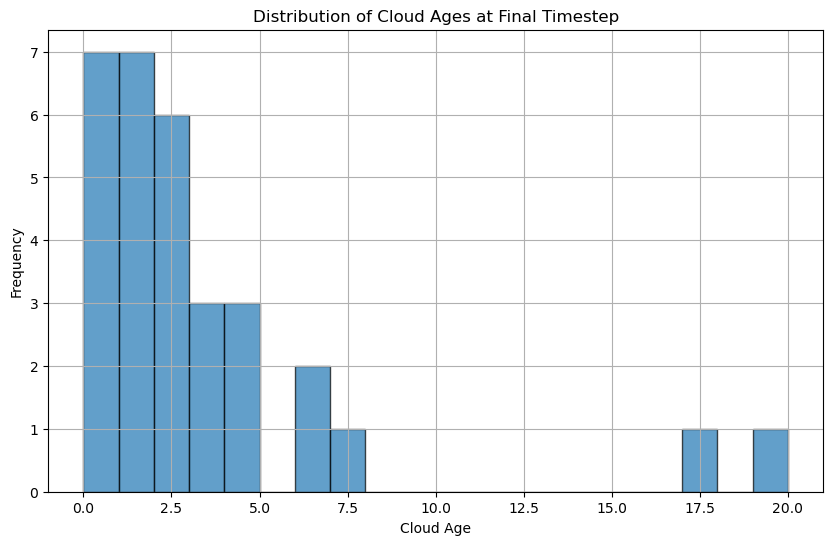

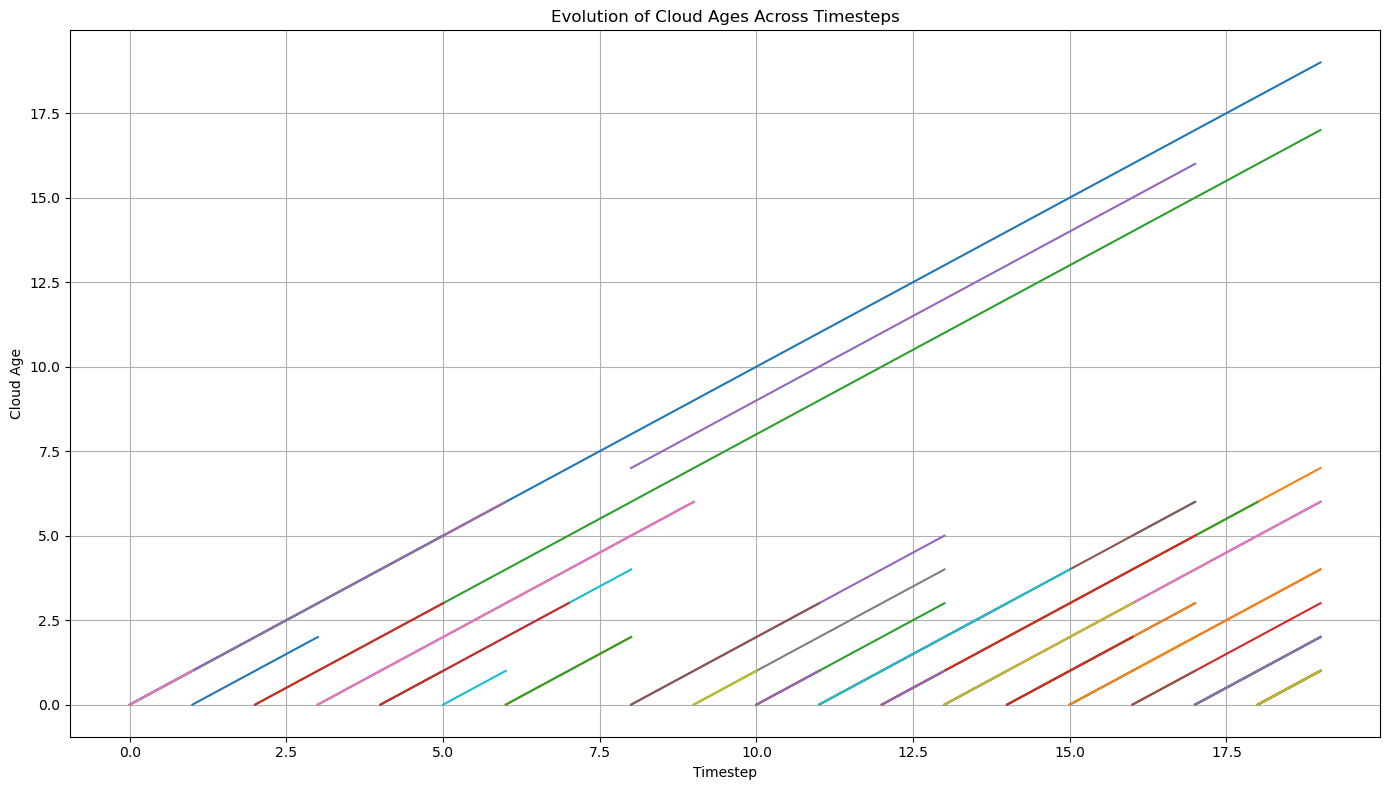

In [24]:
nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

dataset = Dataset(nc_file, 'r')

# Read cloud ages
cloud_ages = dataset.variables['age'][:].T  # Transpose to get shape (timesteps, clouds)

# Number of timesteps and clouds
num_timesteps = cloud_ages.shape[0]
num_clouds = cloud_ages.shape[1]

# Plot 1: Histogram of cloud ages at the final timestep
final_timestep_ages = cloud_ages[-1, :]
final_timestep_ages = final_timestep_ages[final_timestep_ages >= 0]  # Exclude missing values (-1)

plt.figure(figsize=(10, 6))
plt.hist(final_timestep_ages, bins=range(int(final_timestep_ages.max()) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Cloud Age')
plt.ylabel('Frequency')
plt.title('Distribution of Cloud Ages at Final Timestep')
plt.grid(True)
plt.show()

# Plot 2: Evolution of cloud ages across timesteps
plt.figure(figsize=(14, 8))
for cloud_idx in range(num_clouds):
    age_evolution = cloud_ages[:, cloud_idx]
    plt.plot(range(num_timesteps), age_evolution, label=f'Cloud {cloud_idx+1}')
plt.xlabel('Timestep')
plt.ylabel('Cloud Age')
plt.title('Evolution of Cloud Ages Across Timesteps')
plt.grid(True)
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

dataset.close()


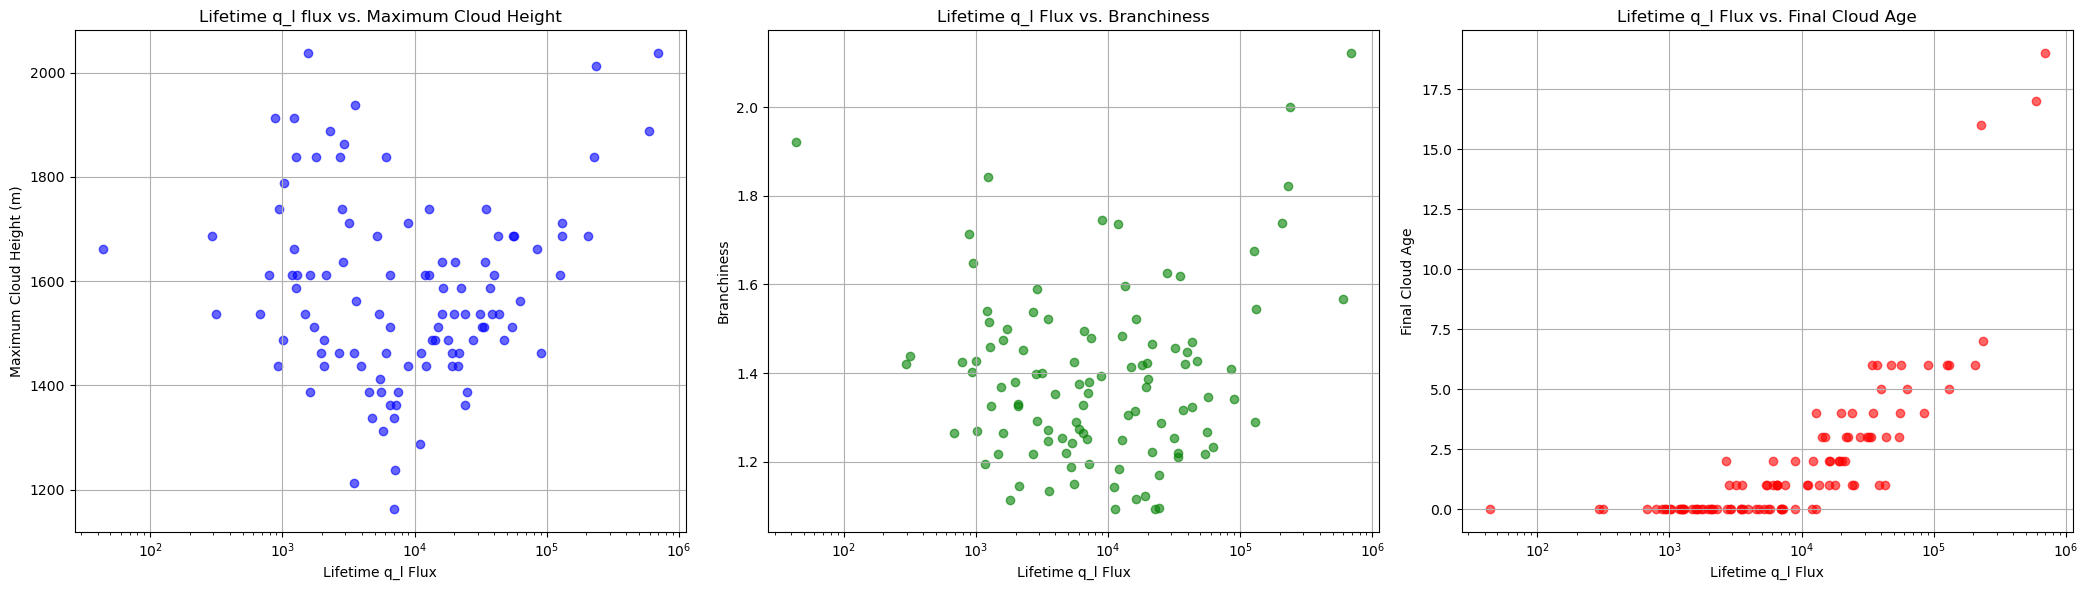

In [23]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
mass_fluxes = dataset.variables['mass_flux'][:].T  # (timesteps, clouds)
max_heights = dataset.variables['max_height'][:].T  # (timesteps, clouds)
cloud_sizes = dataset.variables['size'][:].T  # (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # (timesteps, clouds)
cloud_ages = dataset.variables['age'][:].T  # (timesteps, clouds)

# Initialize lists to store results
lifetime_mass_fluxes = []
max_cloud_heights = []
branchiness_values = []
final_cloud_ages = []

for i in range(mass_fluxes.shape[1]):  # Iterate over clouds
    # Lifetime mass flux: sum over all timesteps for each cloud
    lifetime_mass_flux = np.nansum(mass_fluxes[:, i])
    lifetime_mass_fluxes.append(lifetime_mass_flux)
    
    # Maximum height for each cloud
    max_height = np.nanmax(max_heights[:, i])
    max_cloud_heights.append(max_height)
    
    # Calculate branchiness
    cloud_volume = np.nanmax(cloud_sizes[:, i])  # Max size as proxy for volume
    sphere_surface_area = 4 * np.pi * ((3 * cloud_volume / (4 * np.pi))**(2/3))
    max_surface_area = np.nanmax(cloud_surface_areas[:, i])
    branchiness = max_surface_area / sphere_surface_area
    branchiness_values.append(branchiness)
    
    # Final cloud age
    final_age = np.nanmax(cloud_ages[:, i])
    final_cloud_ages.append(final_age)

# Close the dataset
dataset.close()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

# Scatter plot for Lifetime Mass Flux vs. Max Height
axs[0].scatter(lifetime_mass_fluxes, max_cloud_heights, color='blue', alpha=0.6)
axs[0].set_xscale('log')
axs[0].set_xlabel('Lifetime q_l Flux')
axs[0].set_ylabel('Maximum Cloud Height (m)')
axs[0].set_title('Lifetime q_l flux vs. Maximum Cloud Height')
axs[0].grid(True)

# Scatter plot for Lifetime Mass Flux vs. Branchiness
axs[1].scatter(lifetime_mass_fluxes, branchiness_values, color='green', alpha=0.6)
axs[1].set_xscale('log')
axs[1].set_xlabel('Lifetime q_l Flux')
axs[1].set_ylabel('Branchiness')
axs[1].set_title('Lifetime q_l Flux vs. Branchiness')
axs[1].grid(True)

# Scatter plot for Lifetime Mass Flux vs. Final Cloud Age
axs[2].scatter(lifetime_mass_fluxes, final_cloud_ages, color='red', alpha=0.6)
axs[2].set_xscale('log')
axs[2].set_xlabel('Lifetime q_l Flux')
axs[2].set_ylabel('Final Cloud Age')
axs[2].set_title('Lifetime q_l Flux vs. Final Cloud Age')
axs[2].grid(True)

plt.tight_layout()
plt.show()


## Sanity check
### Check that age of all clouds is 0 when they are born.

In [15]:
from netCDF4 import Dataset
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
cloud_ages = dataset.variables['age'][:].T  # (timesteps, clouds)

# Initialize a list to store clouds that don't start with age 0
clouds_with_nonzero_start_age = []

# Check each cloud
for cloud_idx in range(cloud_ages.shape[1]):  # Iterate over clouds
    # Find the first timestep where the cloud appears
    first_timestep = np.argmax(cloud_ages[:, cloud_idx] >= 0)
    # Check if the age at the first timestep is 0
    if cloud_ages[first_timestep, cloud_idx] != 0:
        clouds_with_nonzero_start_age.append(cloud_idx)

# Close the dataset
dataset.close()

# Print the results
if clouds_with_nonzero_start_age:
    print(f"Clouds that don't start with age 0: {clouds_with_nonzero_start_age}")
else:
    print("All clouds start with age 0")


All clouds start with age 0


# Cloud size and surface area

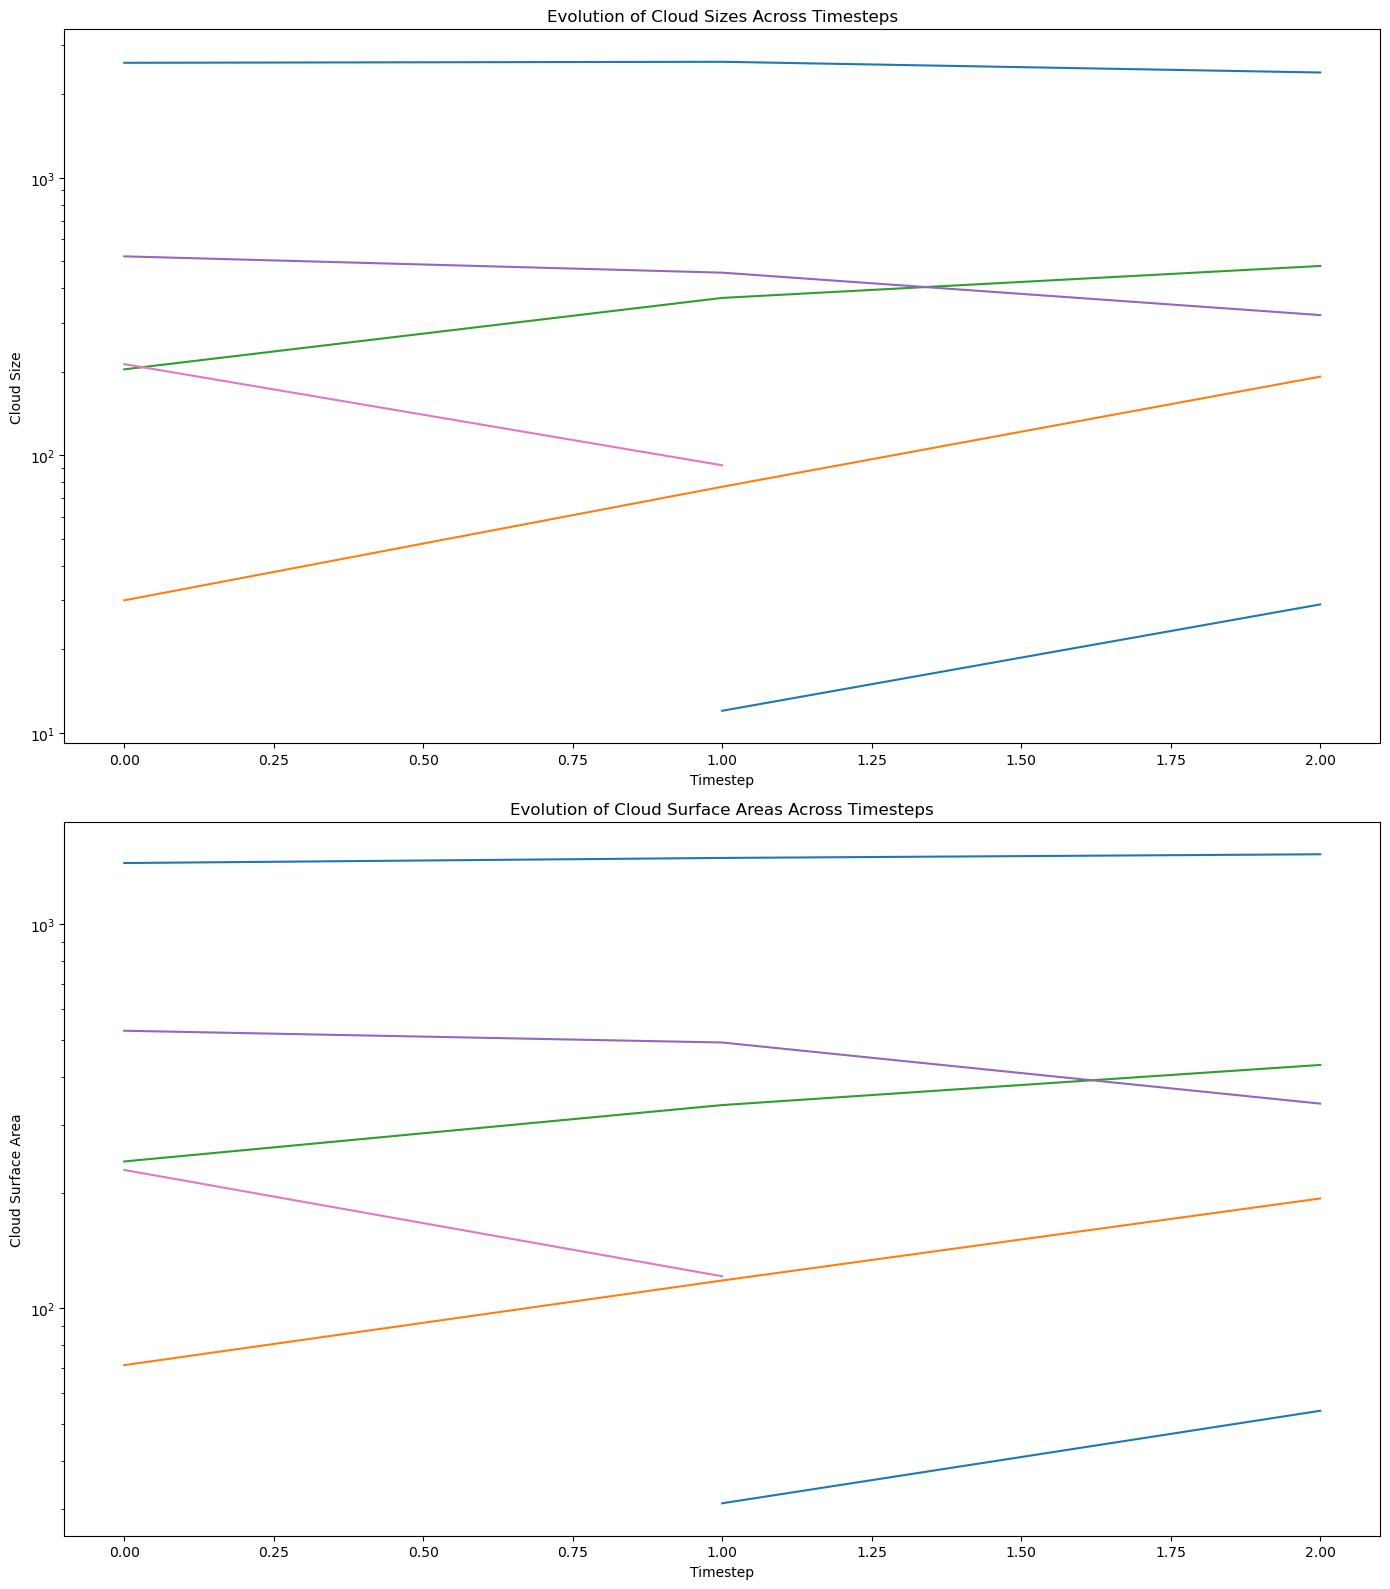

In [3]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

dataset = Dataset(nc_file, 'r')

# Read cloud sizes and surface areas
cloud_sizes = dataset.variables['size'][:].T  # Transpose to get shape (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # Similarly for surface areas

# Number of timesteps and clouds
num_timesteps = cloud_sizes.shape[0]
num_clouds = cloud_sizes.shape[1]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(14, 16))  # Two plots

# Plot for cloud sizes
for cloud_idx in range(num_clouds):
    size_evolution = cloud_sizes[:, cloud_idx]
    # Plot the evolution of sizes
    axes[0].plot(range(num_timesteps), size_evolution, label=f'Cloud {cloud_idx+1}')
axes[0].set_yscale('log')  # Use log scale for cloud sizes
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Cloud Size')
axes[0].set_title('Evolution of Cloud Sizes Across Timesteps')

# Plot for surface areas
for cloud_idx in range(num_clouds):
    surface_area_evolution = cloud_surface_areas[:, cloud_idx]
    # Plot the evolution of surface areas
    axes[1].plot(range(num_timesteps), surface_area_evolution, label=f'Cloud {cloud_idx+1}')
axes[1].set_yscale('log')  # Use log scale for surface areas
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Cloud Surface Area')
axes[1].set_title('Evolution of Cloud Surface Areas Across Timesteps')

plt.tight_layout()  # Adjust layout to not overlap
#plt.legend()
plt.show()
#plt.savefig('surface_and_size.pdf', transparent=True, bbox_inches='tight')
dataset.close()



# Lifetime PDF and CDF

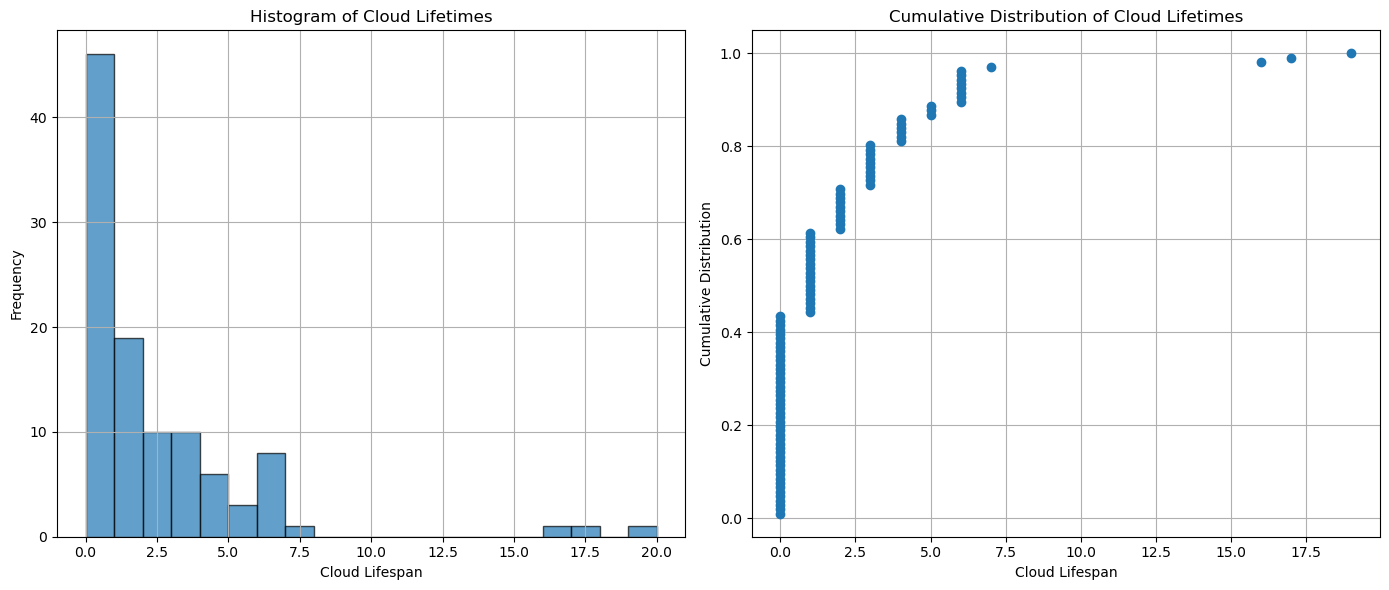

In [27]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
cloud_ages = dataset.variables['age'][:].T  # (timesteps, clouds)

# Extract the final age of each cloud
final_cloud_ages = [np.nanmax(cloud_ages[:, cloud_idx]) for cloud_idx in range(cloud_ages.shape[1])]

# Close the dataset
dataset.close()

# Filter out any invalid ages (e.g., clouds that never appeared)
final_cloud_ages = [age for age in final_cloud_ages if age >= 0]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram (PDF) of cloud lifetimes
axs[0].hist(final_cloud_ages, bins=range(int(max(final_cloud_ages)) + 2), edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Cloud Lifespan')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Cloud Lifetimes')
axs[0].grid(True)

# Cumulative distribution (CDF) of cloud lifetimes
sorted_ages = np.sort(final_cloud_ages)
cumulative = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages)
axs[1].plot(sorted_ages, cumulative, marker='o', linestyle='none')
axs[1].set_xlabel('Cloud Lifespan')
axs[1].set_ylabel('Cumulative Distribution')
axs[1].set_title('Cumulative Distribution of Cloud Lifetimes')
axs[1].grid(True)

plt.tight_layout()
plt.show()


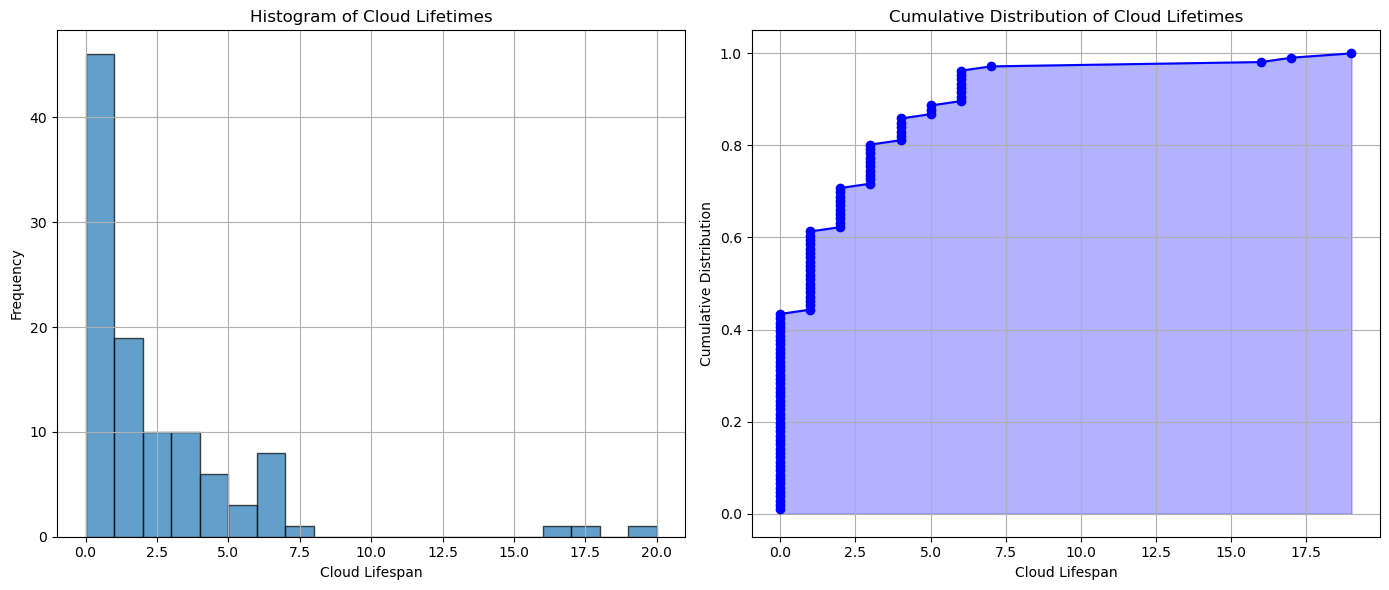

In [28]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
cloud_ages = dataset.variables['age'][:].T  # (timesteps, clouds)

# Extract the final age of each cloud
final_cloud_ages = [np.nanmax(cloud_ages[:, cloud_idx]) for cloud_idx in range(cloud_ages.shape[1])]

# Close the dataset
dataset.close()

# Filter out any invalid ages (e.g., clouds that never appeared)
final_cloud_ages = [age for age in final_cloud_ages if age >= 0]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram (PDF) of cloud lifetimes
axs[0].hist(final_cloud_ages, bins=range(int(max(final_cloud_ages)) + 2), edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Cloud Lifespan')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Cloud Lifetimes')
axs[0].grid(True)

# Cumulative distribution (CDF) of cloud lifetimes
sorted_ages = np.sort(final_cloud_ages)
cumulative = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages)
axs[1].plot(sorted_ages, cumulative, marker='o', linestyle='-', color='blue')
axs[1].fill_between(sorted_ages, cumulative, color='blue', alpha=0.3)
axs[1].set_xlabel('Cloud Lifespan')
axs[1].set_ylabel('Cumulative Distribution')
axs[1].set_title('Cumulative Distribution of Cloud Lifetimes')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Warning!

All plots below that refer to cloud age needs to be updated to use the newly added variable `age` rather than just adding up the number of timesteps that a cloud is alive. The latter method is wrong as it does not take into account merging/splitting.

# Liquid water flux

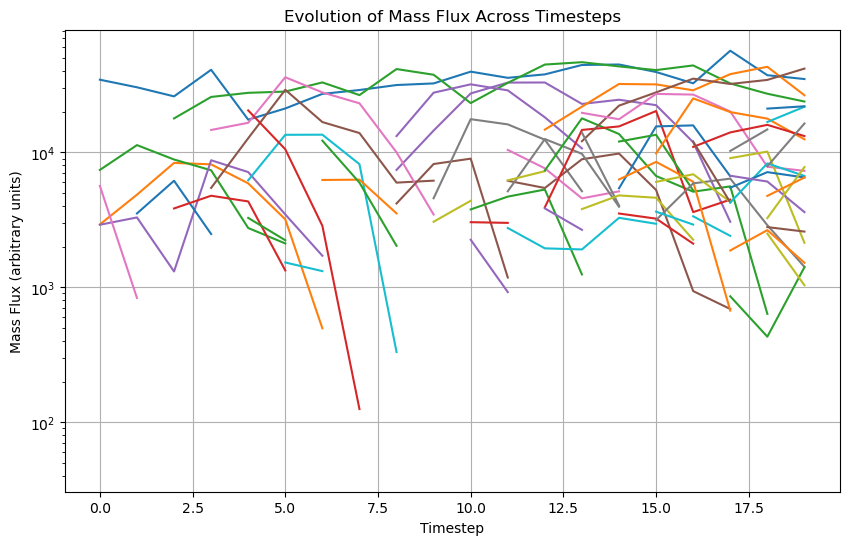

In [29]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

dataset = Dataset(nc_file, 'r')

# Read mass fluxes, assuming the variable name is 'mass_flux'
mass_fluxes = dataset.variables['mass_flux'][:].T  # Transpose to get shape (timesteps, clouds)

# Number of timesteps and clouds
num_timesteps = mass_fluxes.shape[0]
num_clouds = mass_fluxes.shape[1]

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot for mass fluxes
for cloud_idx in range(num_clouds):
    flux_evolution = mass_fluxes[:, cloud_idx]
    # Plot the evolution of mass flux
    plt.plot(range(num_timesteps), flux_evolution, label=f'Cloud {cloud_idx+1}')

plt.xlabel('Timestep')
plt.ylabel('Mass Flux (arbitrary units)')
plt.title('Evolution of Mass Flux Across Timesteps')
plt.yscale('log')  # Use log scale if the range is large
plt.grid(True)
#plt.legend()  # Uncomment this if you want to see labels for each cloud
plt.show()

dataset.close()


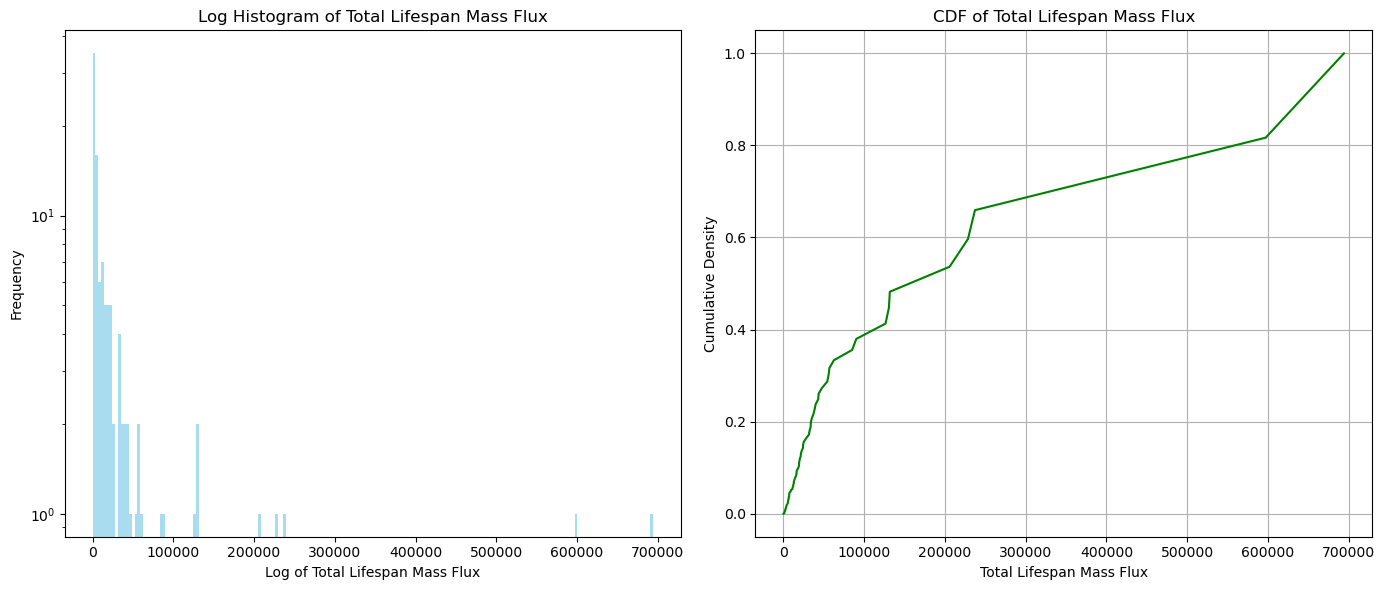

In [30]:
nc_file = '../cloud_results.nc'  # Update this path if necessary
dataset = Dataset(nc_file, 'r')

# Read mass flux data
mass_fluxes = dataset.variables['mass_flux'][:].T  # (timesteps, clouds)

# Calculate total lifespan mass flux for each cloud
total_mass_fluxes = np.nansum(mass_fluxes, axis=0)  # Sum over all timesteps

# Close the dataset
dataset.close()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of total lifespan mass flux
axs[0].hist(total_mass_fluxes, bins=200, color='skyblue', alpha=0.7)
axs[0].set_yscale('log')

axs[0].set_xlabel('Log of Total Lifespan Mass Flux')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Log Histogram of Total Lifespan Mass Flux')

# Cumulative Density Function (CDF)
# Sort the data and calculate the proportional values for the CDF
sorted_fluxes = np.sort(total_mass_fluxes)
cumulative = np.cumsum(sorted_fluxes) / np.sum(sorted_fluxes)
axs[1].plot(sorted_fluxes, cumulative, color='green')
axs[1].set_xlabel('Total Lifespan Mass Flux')
axs[1].set_ylabel('Cumulative Density')
axs[1].set_title('CDF of Total Lifespan Mass Flux')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Total life mass flux vs max heights and branchiness

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


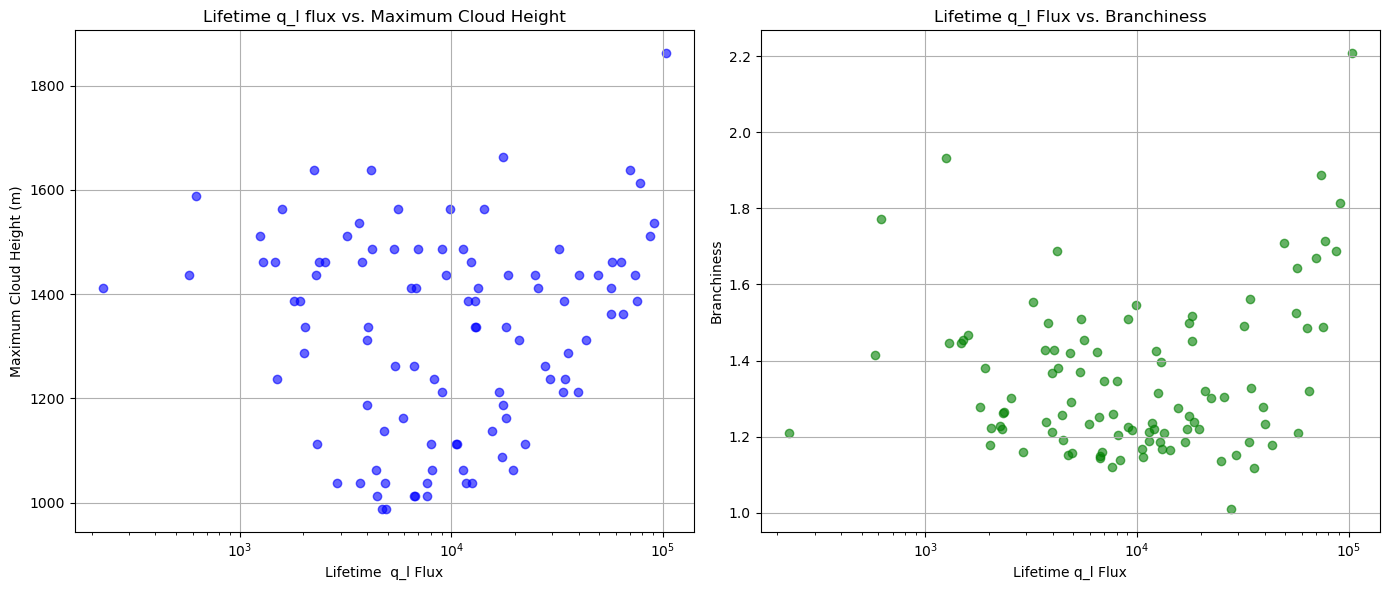

In [20]:
nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
mass_fluxes = dataset.variables['mass_flux'][:].T  # (timesteps, clouds)
max_heights = dataset.variables['max_height'][:].T  # (timesteps, clouds)
cloud_sizes = dataset.variables['size'][:].T  # (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # (timesteps, clouds)

# Initialize lists to store results
lifetime_mass_fluxes = []
max_cloud_heights = []
branchiness_values = []

for i in range(mass_fluxes.shape[1]):  # Iterate over clouds
    # Lifetime mass flux: sum over all timesteps for each cloud
    lifetime_mass_flux = np.nansum(mass_fluxes[:, i])
    lifetime_mass_fluxes.append(lifetime_mass_flux)
    
    # Maximum height for each cloud
    max_height = np.nanmax(max_heights[:, i])
    max_cloud_heights.append(max_height)
    
    # Calculate branchiness
    cloud_volume = np.nanmax(cloud_sizes[:, i])  # Max size as proxy for volume
    sphere_surface_area = 4 * np.pi * ((3 * cloud_volume / (4 * np.pi))**(2/3))
    max_surface_area = np.nanmax(cloud_surface_areas[:, i])
    branchiness = max_surface_area / sphere_surface_area
    branchiness_values.append(branchiness)

# Close the dataset
dataset.close()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for Lifetime Mass Flux vs. Max Height
axs[0].scatter(lifetime_mass_fluxes, max_cloud_heights, color='blue', alpha=0.6)
axs[0].set_xscale('log')
axs[0].set_xlabel('Lifetime  q_l Flux')
axs[0].set_ylabel('Maximum Cloud Height (m)')
axs[0].set_title('Lifetime q_l flux vs. Maximum Cloud Height')
axs[0].grid(True)

# Scatter plot for Lifetime Mass Flux vs. Branchiness
axs[1].scatter(lifetime_mass_fluxes, branchiness_values, color='green', alpha=0.6)
axs[1].set_xscale('log')
axs[1].set_xlabel('Lifetime q_l Flux')
axs[1].set_ylabel('Branchiness')
axs[1].set_title('Lifetime q_l Flux vs. Branchiness')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Mean mass flux vs lifetime

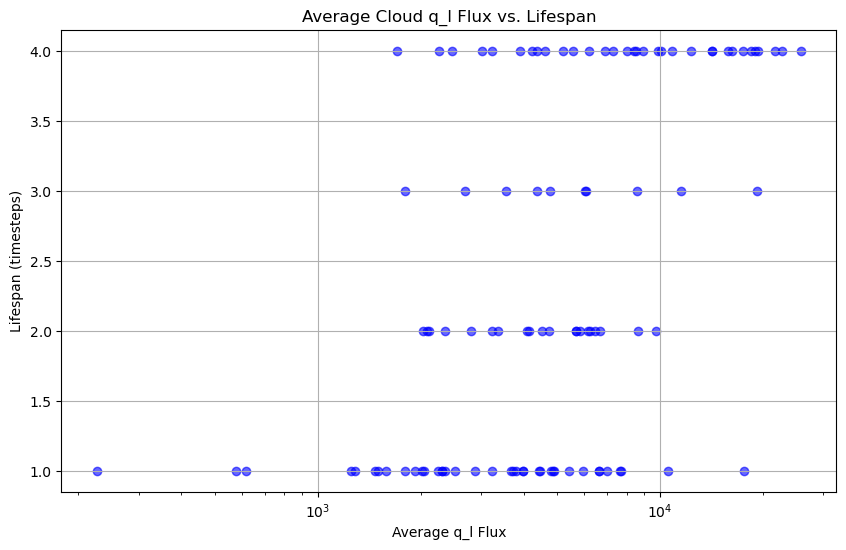

In [21]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the mass flux data
mass_fluxes = dataset.variables['mass_flux'][:].T  # Transpose to (timesteps, clouds)

# Calculate the average mass flux and lifespan for each cloud
average_mass_fluxes = []
lifespans = []

for cloud_fluxes in mass_fluxes.T:  # Iterate over clouds (transpose to iterate correctly)
    # Filter out NaN values for each cloud to find active mass flux data
    active_fluxes = cloud_fluxes[~np.isnan(cloud_fluxes)]
    if active_fluxes.size > 0:
        average_flux = np.mean(active_fluxes)
        lifespan = len(active_fluxes)  # Count of non-NaN entries is the lifespan
        average_mass_fluxes.append(average_flux)
        lifespans.append(lifespan)

# Close the dataset
dataset.close()

# Create scatter plot of average mass flux vs. lifespan
plt.figure(figsize=(10, 6))
plt.scatter(average_mass_fluxes, lifespans, color='blue', alpha=0.6)
plt.xscale('log')
plt.xlabel('Average q_l Flux')
plt.ylabel('Lifespan (timesteps)')
#plt.xlim([-0.1,10])
plt.title('Average Cloud q_l Flux vs. Lifespan')
plt.grid(True)
plt.show()


# Mass flux vs branchiness

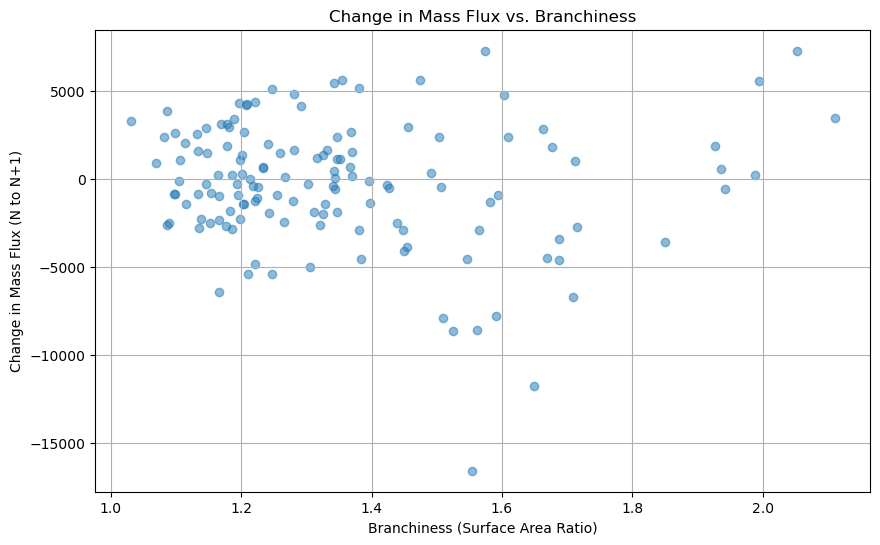

In [22]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
mass_fluxes = dataset.variables['mass_flux'][:].T  # (timesteps, clouds)
cloud_sizes = dataset.variables['size'][:].T  # (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # (timesteps, clouds)

# Initialize lists to store results
branchiness_values = []
mass_flux_changes = []

# Calculate mass flux change and branchiness for each timestep for each cloud
for i in range(mass_fluxes.shape[1]):  # Iterate over clouds
    for t in range(mass_fluxes.shape[0] - 1):  # Iterate over timesteps, excluding the last because of the diff calculation
        # Calculate mass flux change between consecutive timesteps
        mass_flux_change = mass_fluxes[t+1, i] - mass_fluxes[t, i]
        mass_flux_changes.append(mass_flux_change)
        
        # Calculate branchiness at timestep t
        cloud_volume = cloud_sizes[t, i]  # Use size at timestep t
        sphere_surface_area = 4 * np.pi * ((3 * cloud_volume / (4 * np.pi))**(2/3))
        cloud_surface_area = cloud_surface_areas[t, i]
        branchiness = cloud_surface_area / sphere_surface_area
        branchiness_values.append(branchiness)

# Close the dataset
dataset.close()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(branchiness_values, mass_flux_changes, alpha=0.5)
#plt.yscale('log')
plt.xlabel('Branchiness (Surface Area Ratio)')
plt.ylabel('Change in Mass Flux (N to N+1)')
plt.title('Change in Mass Flux vs. Branchiness')
plt.grid(True)
plt.show()


# Linear fit for liquid water flux vs branchiness
Take only negative mass flux values (ones for which mass flux is decreasing), find the corresponding value for branchiness (in the step beforehand). Use log scale for mass flux values and fit a linear function

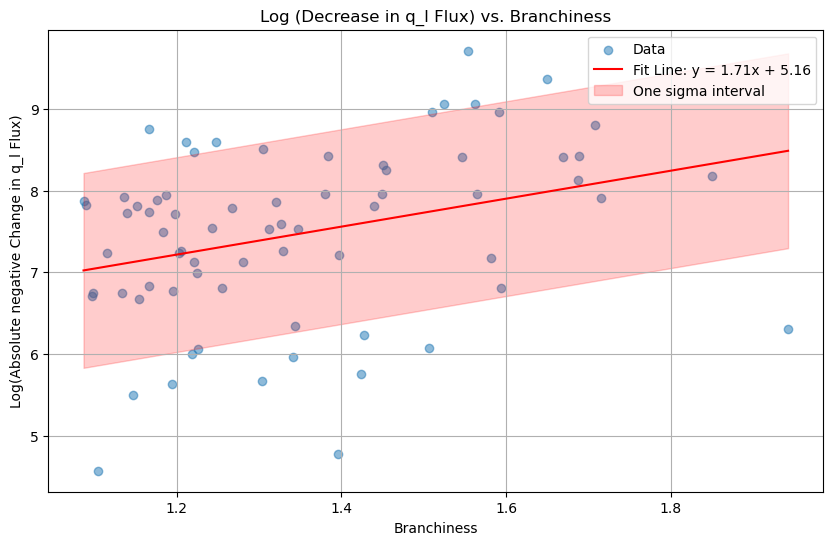

R-squared: 0.10284739810454653
P-value: 0.006396927762357172
Standard error: 0.6088290278088268


In [23]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file

# Open the dataset
dataset = Dataset(nc_file, 'r')

# Read the required data
mass_fluxes = dataset.variables['mass_flux'][:].T  # (timesteps, clouds)
cloud_sizes = dataset.variables['size'][:].T  # (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # (timesteps, clouds)

# Initialize lists to store results
branchiness_values = []
mass_flux_changes = []

# Calculate mass flux change and branchiness for each timestep for each cloud
for i in range(mass_fluxes.shape[1]):  # Iterate over clouds
    for t in range(mass_fluxes.shape[0] - 1):  # Iterate over timesteps, excluding the last because of the diff calculation
        # Calculate mass flux change between consecutive timesteps
        mass_flux_change = mass_fluxes[t+1, i] - mass_fluxes[t, i]
        
        if mass_flux_change < 0:  # Consider only negative changes
            mass_flux_changes.append(np.abs(mass_flux_change))  # Take the absolute value
            
            # Calculate branchiness at timestep t
            cloud_volume = cloud_sizes[t, i]  # Use size at timestep t
            sphere_surface_area = 4 * np.pi * ((3 * cloud_volume / (4 * np.pi))**(2/3))
            cloud_surface_area = cloud_surface_areas[t, i]
            branchiness = cloud_surface_area / sphere_surface_area
            branchiness_values.append(branchiness)

# Close the dataset
dataset.close()

# Log scale transformation for mass flux changes
log_mass_flux_changes = np.log(mass_flux_changes)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(branchiness_values, log_mass_flux_changes)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(branchiness_values, log_mass_flux_changes, alpha=0.5, label='Data')

# Calculate fitted values for plot
fit_x = np.linspace(min(branchiness_values), max(branchiness_values), 100)
fit_y = slope * fit_x + intercept
plt.plot(fit_x, fit_y, 'r-', label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}')

# Calculate confidence interval for the fit
ci = 1.96 * std_err
plt.fill_between(fit_x, fit_y - ci, fit_y + ci, color='red', alpha=0.2, label='One sigma interval')

plt.xlabel('Branchiness')
plt.ylabel('Log(Absolute negative Change in q_l Flux)')
plt.title(f'Log (Decrease in q_l Flux) vs. Branchiness')
plt.legend()
plt.grid(True)
plt.show()

# Print regression results
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


# Branchiness with time

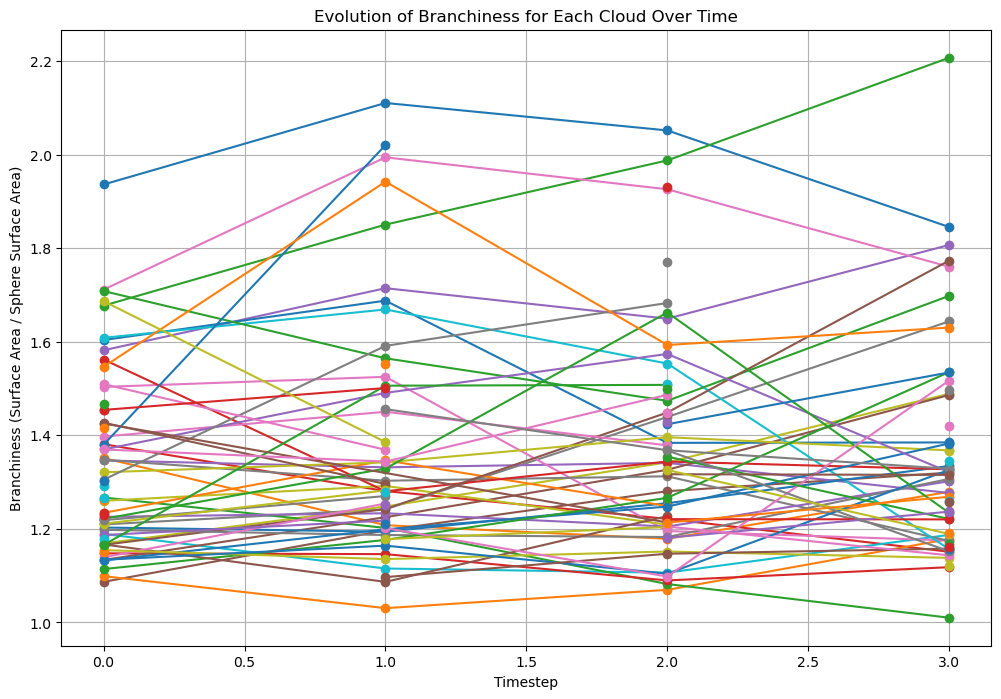

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

# Load the NetCDF file
nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file
dataset = Dataset(nc_file, 'r')

# Read necessary data
cloud_sizes = dataset.variables['size'][:].T  # Transpose to get shape (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # Similarly for surface areas

# Number of timesteps and clouds
num_timesteps = cloud_sizes.shape[0]
num_clouds = cloud_sizes.shape[1]

# Initialize a plot
plt.figure(figsize=(12, 8))

# Iterate over each cloud
for cloud_idx in range(num_clouds):
    # Extract size and surface area for the current cloud
    sizes = cloud_sizes[:, cloud_idx]
    surface_areas = cloud_surface_areas[:, cloud_idx]
    
    # Calculate volume using size (assuming size approximates volume directly)
    volumes = sizes  # Replace this with actual volume calculation if different
    
    # Calculate branchiness across all timesteps for this cloud
    sphere_surface_areas = 4 * np.pi * ((3 * volumes / (4 * np.pi))**(2/3))
    branchiness = surface_areas / sphere_surface_areas
    
    # Filter to only plot when the cloud is active (surface area and size are non-NaN)
    active_indices = ~np.isnan(branchiness)
    
    # Plot branchiness over time
    if any(active_indices):
        plt.plot(np.arange(num_timesteps)[active_indices], branchiness[active_indices], marker='o', linestyle='-', label=f'Cloud {cloud_idx+1}')

plt.xlabel('Timestep')
plt.ylabel('Branchiness (Surface Area / Sphere Surface Area)')
plt.title('Evolution of Branchiness for Each Cloud Over Time')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Close the dataset
dataset.close()


## Filtered for minimum length and translated to start at 0 time for all

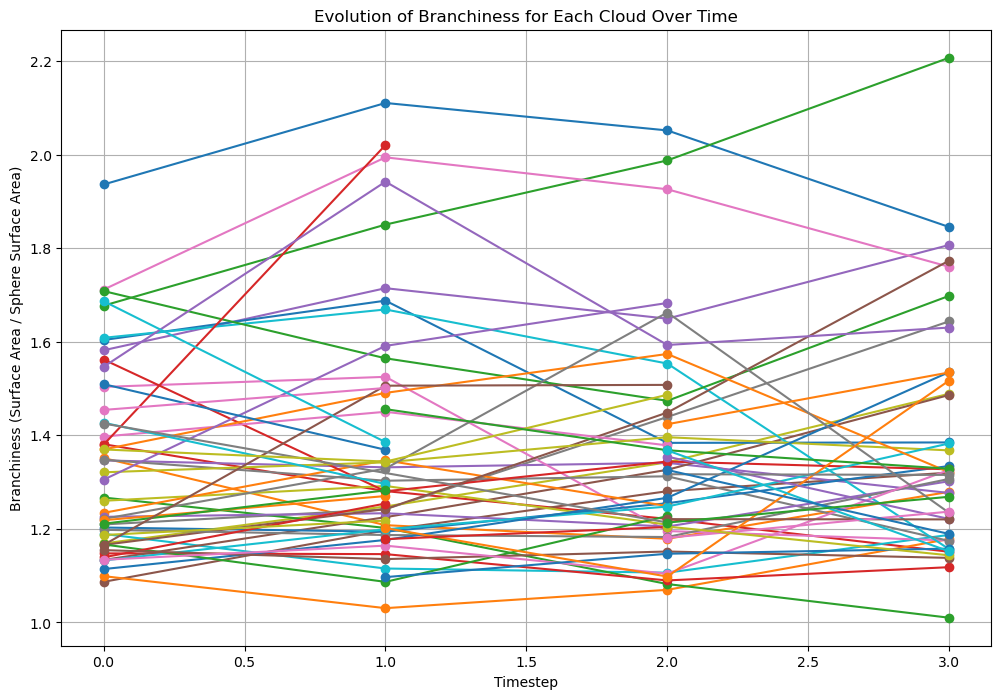

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

# Load the NetCDF file
nc_file = '../cloud_results.nc'  # Replace with the actual path to your NetCDF file
dataset = Dataset(nc_file, 'r')

# Read necessary data
cloud_sizes = dataset.variables['size'][:].T  # Transpose to get shape (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # Similarly for surface areas

# Number of timesteps and clouds
num_timesteps = cloud_sizes.shape[0]
num_clouds = cloud_sizes.shape[1]

# Initialize a plot
plt.figure(figsize=(12, 8))

# Iterate over each cloud
for cloud_idx in range(num_clouds):
    # Extract size and surface area for the current cloud
    sizes = cloud_sizes[:, cloud_idx]
    surface_areas = cloud_surface_areas[:, cloud_idx]
    
    # Calculate volume using size (assuming size approximates volume directly)
    volumes = sizes  # Replace this with actual volume calculation if different
    
    # Calculate branchiness across all timesteps for this cloud
    sphere_surface_areas = 4 * np.pi * ((3 * volumes / (4 * np.pi))**(2/3))
    branchiness = surface_areas / sphere_surface_areas
    
    # Filter to only plot when the cloud is active (surface area and size are non-NaN)
    active_indices = ~np.isnan(branchiness)
    
    # Filter out clouds with less than 5 active timesteps
    if np.count_nonzero(active_indices) >= 5:
        plt.plot(np.arange(num_timesteps)[active_indices], branchiness[active_indices], marker='o', linestyle='-', label=f'Cloud {cloud_idx+1}')

plt.xlabel('Timestep')
plt.ylabel('Branchiness (Surface Area / Sphere Surface Area)')
plt.title('Evolution of Branchiness for Each Cloud Over Time')
plt.grid(True)
plt.show()

# Close the dataset
dataset.close()


## Branchiness mean value with time

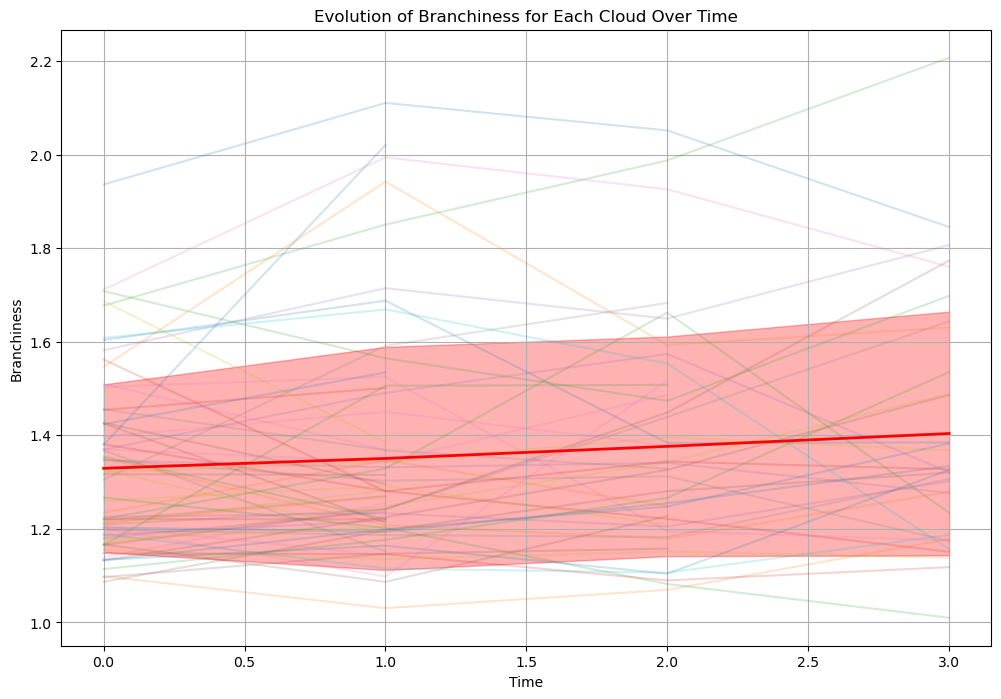

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

minimum_lifetime_length = 1

# Load the NetCDF file
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Read necessary data
cloud_sizes = dataset.variables['size'][:].T  # Transpose to get shape (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # Similarly for surface areas

# Number of timesteps and clouds
num_timesteps = cloud_sizes.shape[0]
num_clouds = cloud_sizes.shape[1]

# Initialize a plot
plt.figure(figsize=(12, 8))

# List to store adjusted branchiness arrays for averaging
normalized_branchiness = []

# Iterate over each cloud
for cloud_idx in range(num_clouds):
    # Extract size and surface area for the current cloud
    sizes = cloud_sizes[:, cloud_idx]
    surface_areas = cloud_surface_areas[:, cloud_idx]
    
    # Calculate volume using size (assuming size approximates volume directly)
    volumes = sizes
    
    # Calculate branchiness across all timesteps for this cloud
    sphere_surface_areas = 4 * np.pi * ((3 * volumes / (4 * np.pi))**(2/3))
    branchiness = surface_areas / sphere_surface_areas
    
    # Filter to only plot when the cloud is active (surface area and size are non-NaN)
    active_indices = ~np.isnan(branchiness)
    active_branchiness = branchiness[active_indices]
    
    # Normalize start times to 0 for each cloud
    if len(active_branchiness) >= minimum_lifetime_length:  # Ensure at least 5 timesteps of activity
        normalized_branchiness.append(active_branchiness)
        plt.plot(range(len(active_branchiness)), active_branchiness, linestyle='-', alpha = 0.2)

# Calculate and plot the mean branchiness at each normalized timestep
if normalized_branchiness:
    max_length = max(map(len, normalized_branchiness))  # Find the longest cloud lifespan
    # Initialize an array to store sum for averaging
    sum_array = np.zeros(max_length)
    count_array = np.zeros(max_length)
    all_data = np.full((len(normalized_branchiness), max_length), np.nan)
    
    for i, branchiness in enumerate(normalized_branchiness):
        sum_array[:len(branchiness)] += branchiness
        count_array[:len(branchiness)] += 1
        all_data[i, :len(branchiness)] = branchiness
    
    mean_branchiness = sum_array / count_array
    std_deviation = np.nanstd(all_data, axis=0)  # Calculate standard deviation at each timestep

    # Plot mean with shaded standard deviation
    plt.plot(range(max_length), mean_branchiness, color='red', linestyle='-', linewidth=2, label='Average Branchiness')
    plt.fill_between(range(max_length), mean_branchiness - std_deviation, mean_branchiness + std_deviation, color='red', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Branchiness')
plt.title('Evolution of Branchiness for Each Cloud Over Time')
plt.grid(True)
plt.show()

# Close the dataset
dataset.close()


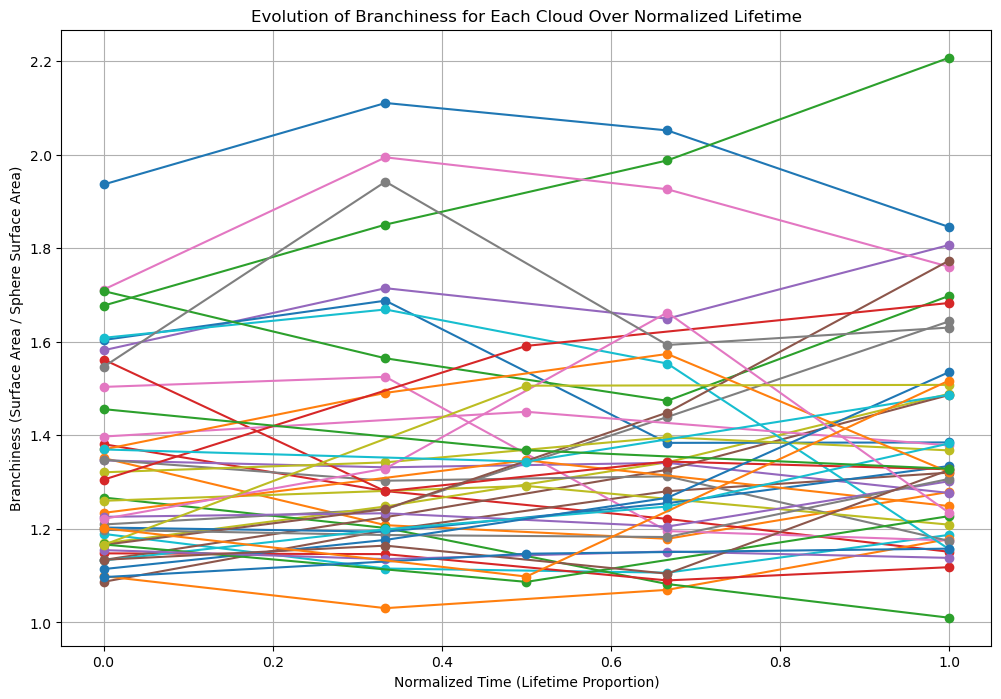

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

# Load the NetCDF file
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Read necessary data
cloud_sizes = dataset.variables['size'][:].T  # Transpose to get shape (timesteps, clouds)
cloud_surface_areas = dataset.variables['surface_area'][:].T  # Similarly for surface areas

# Number of timesteps and clouds
num_timesteps = cloud_sizes.shape[0]
num_clouds = cloud_sizes.shape[1]

# Initialize a plot
plt.figure(figsize=(12, 8))

# Iterate over each cloud
for cloud_idx in range(num_clouds):
    # Extract size and surface area for the current cloud
    sizes = cloud_sizes[:, cloud_idx]
    surface_areas = cloud_surface_areas[:, cloud_idx]
    
    # Calculate volume using size (assuming size approximates volume directly)
    volumes = sizes  # Replace this with actual volume calculation if different
    
    # Calculate branchiness across all timesteps for this cloud
    sphere_surface_areas = 4 * np.pi * ((3 * volumes / (4 * np.pi))**(2/3))
    branchiness = surface_areas / sphere_surface_areas
    
    # Filter to only plot when the cloud is active (surface area and size are non-NaN)
    active_indices = ~np.isnan(branchiness)
    active_timesteps = np.arange(num_timesteps)[active_indices]
    
    # Filter out clouds with less than 5 active timesteps
    if len(active_timesteps) >= 5:
        # Normalize the time axis for each cloud from 0 to 1
        normalized_time = (active_timesteps - active_timesteps[0]) / (active_timesteps[-1] - active_timesteps[0])
        
        # Plot branchiness over normalized time
        plt.plot(normalized_time, branchiness[active_indices], marker='o', linestyle='-', label=f'Cloud {cloud_idx+1}')

plt.xlabel('Normalized Time (Lifetime Proportion)')
plt.ylabel('Branchiness (Surface Area / Sphere Surface Area)')
plt.title('Evolution of Branchiness for Each Cloud Over Normalized Lifetime')
plt.grid(True)
plt.show()

# Close the dataset
dataset.close()


# Cloud height

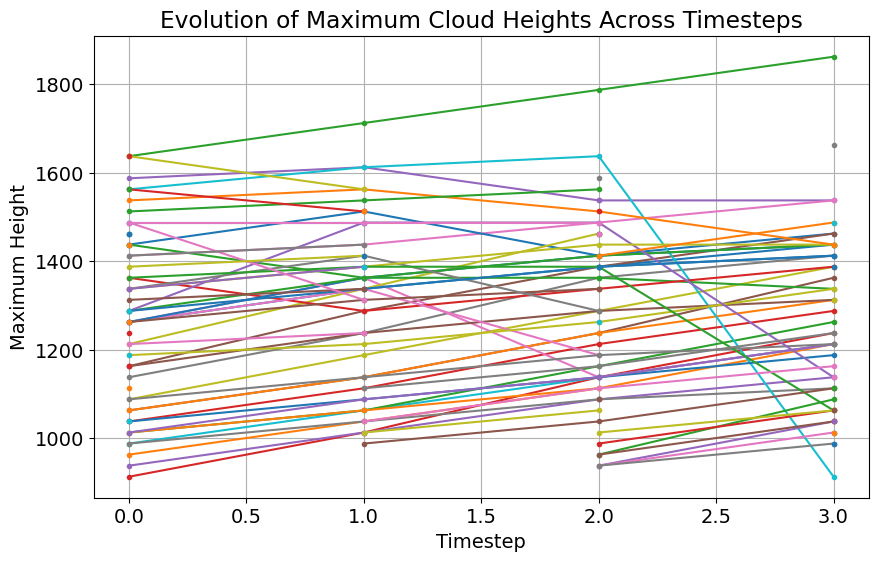

In [31]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load the NetCDF file
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Read maximum heights, assuming variable name is 'max_height' with dimensions ('track', 'time')
max_heights = dataset.variables['max_height'][:].T  # Transpose to match ('time', 'track')

# Filter out tracks where all entries are NaN (no active data throughout the simulation)
max_heights = np.array([track for track in max_heights if not np.all(np.isnan(track))])

# Number of timesteps and clouds
num_timesteps = max_heights.shape[0]
num_clouds = max_heights.shape[1]

# Generate a plot for maximum heights
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})
for cloud_idx in range(num_clouds):
    height_evolution = max_heights[:, cloud_idx]
    # Plot only if there are actual data points to plot
    if np.any(~np.isnan(height_evolution)):
        plt.plot(range(num_timesteps), height_evolution, marker='.', label=f'Cloud {cloud_idx+1}')

plt.xlabel('Timestep')
plt.ylabel('Maximum Height')
plt.title('Evolution of Maximum Cloud Heights Across Timesteps')
#plt.legend()
plt.grid(True)
plt.savefig('Max_height.pdf', transparent=True, format='pdf', bbox_inches='tight')
plt.show()

dataset.close()


# Optionally print the maximum heights data
#print(max_heights)


# Cloud Base

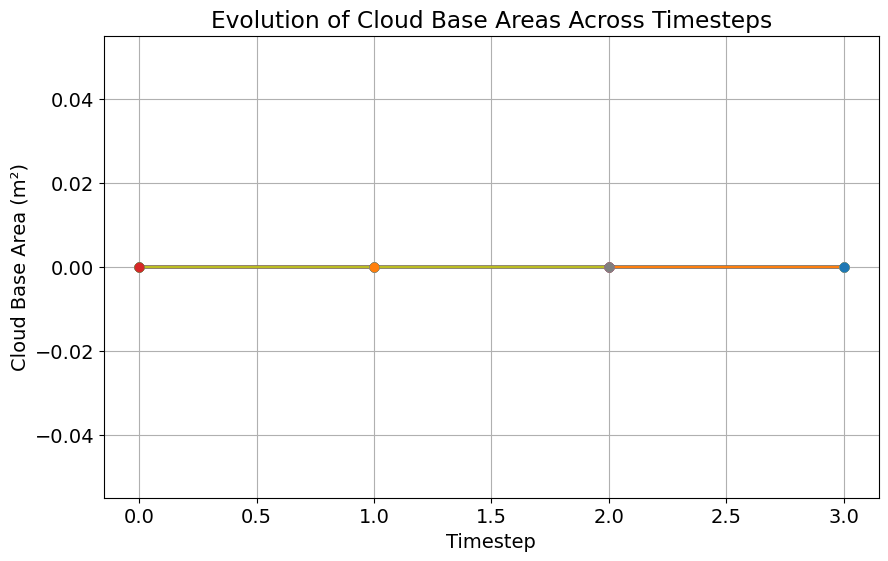

In [32]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load the NetCDF file
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Read cloud base areas, assuming variable name is 'cloud_base_area' with dimensions ('track', 'time')
cloud_base_areas = dataset.variables['cloud_base_area'][:].T  # Transpose to match ('time', 'track')

# Filter out tracks where all entries are NaN (no active data throughout the simulation)
cloud_base_areas = np.array([track for track in cloud_base_areas if not np.all(np.isnan(track))])

# Number of timesteps and clouds
num_timesteps = cloud_base_areas.shape[0]
num_clouds = cloud_base_areas.shape[1]

# Generate a plot for cloud base areas
plt.figure(figsize=(10, 6))
for cloud_idx in range(num_clouds):
    base_area_evolution = cloud_base_areas[:, cloud_idx]
    # Plot only if there are actual data points to plot
    if np.any(~np.isnan(base_area_evolution)):
        plt.plot(range(num_timesteps), base_area_evolution, marker='o', linestyle='-', label=f'Cloud {cloud_idx+1}')

plt.xlabel('Timestep')
plt.ylabel('Cloud Base Area (m²)')
plt.title('Evolution of Cloud Base Areas Across Timesteps')
plt.grid(True)
plt.show()

dataset.close()

# Optionally print the cloud base areas data
#print(cloud_base_areas)


# Max cloud w and Max cloud w at cloud base

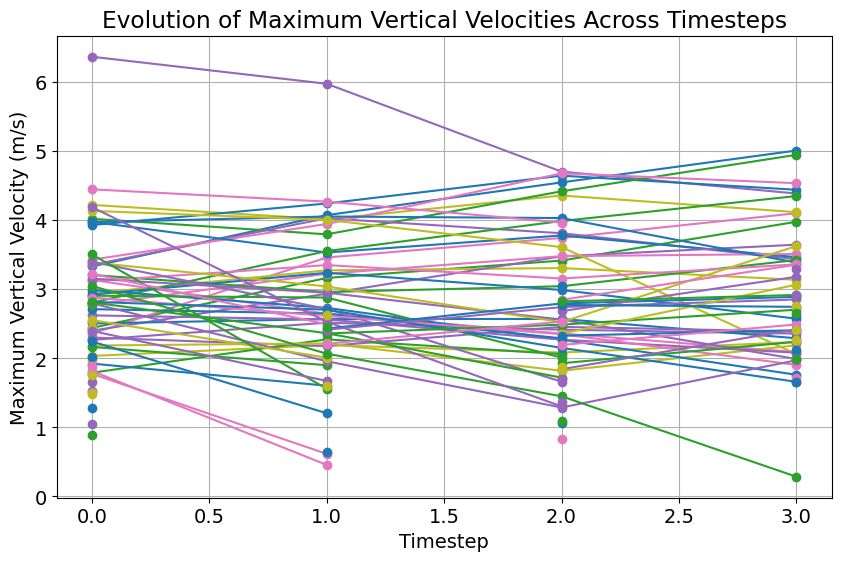

In [33]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load the NetCDF file
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Read max_w and max_w_cloud_base data
max_w = dataset.variables['max_w'][:].T  # Transpose to match ('time', 'track')
max_w_cloud_base = dataset.variables['max_w_cloud_base'][:].T  # Transpose to match ('time', 'track')

# Filter out tracks where all entries are NaN (no active data throughout the simulation)
max_w = np.array([track for track in max_w if not np.all(np.isnan(track))])
max_w_cloud_base = np.array([track for track in max_w_cloud_base if not np.all(np.isnan(track))])

# Number of timesteps and clouds
num_timesteps = max_w.shape[0]
num_clouds = max_w.shape[1]

# Generate a plot for max_w and max_w_cloud_base
plt.figure(figsize=(10, 6))
for cloud_idx in range(num_clouds):
    w_evolution = max_w[:, cloud_idx]
    w_base_evolution = max_w_cloud_base[:, cloud_idx]
    # Plot only if there are actual data points to plot
    if np.any(~np.isnan(w_evolution)) or np.any(~np.isnan(w_base_evolution)):
        plt.plot(range(num_timesteps), w_evolution, marker='o', linestyle='-', label=f'Max W Cloud {cloud_idx+1}')
        plt.plot(range(num_timesteps), w_base_evolution, marker='x', linestyle='--', label=f'Max W Base Cloud {cloud_idx+1}')

plt.xlabel('Timestep')
plt.ylabel('Maximum Vertical Velocity (m/s)')
plt.title('Evolution of Maximum Vertical Velocities Across Timesteps')
#plt.legend(loc='upper left')
plt.grid(True)
plt.show()

dataset.close()


# Vertical velocity against branchiness

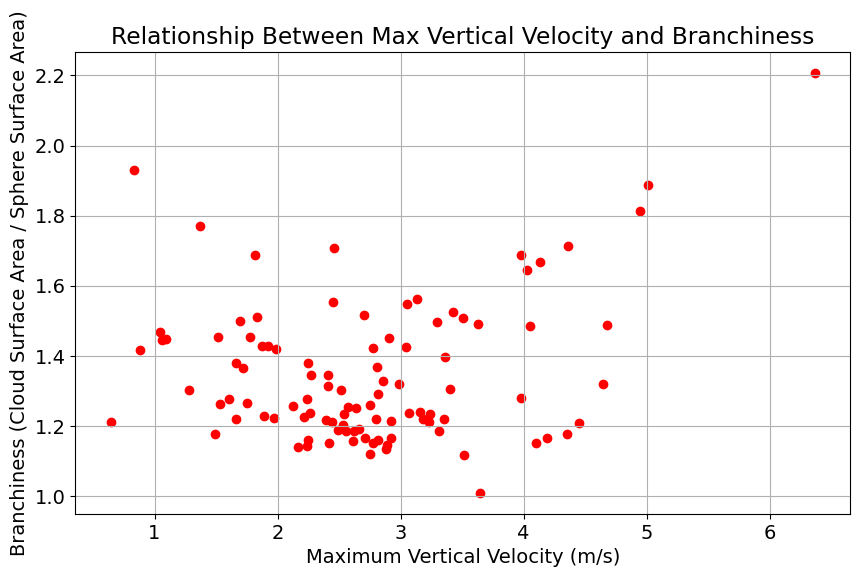

In [34]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load the NetCDF file
nc_file = '../cloud_results.nc'  # Update this path
dataset = Dataset(nc_file, 'r')

# Read maximum vertical velocities, surface areas, and cloud sizes
max_ws = dataset.variables['max_w'][:].T  # Transpose to match ('time', 'track')
cloud_surface_areas = dataset.variables['surface_area'][:].T
cloud_sizes = dataset.variables['size'][:].T

# Calculate the maximum vertical velocity for each cloud across all timesteps
max_cloud_ws = np.nanmax(max_ws, axis=0)

# Calculate maximum surface areas for each cloud across all timesteps
max_surface_areas = np.nanmax(cloud_surface_areas, axis=0)

# Assume cloud size as volume for simplicity (replace with actual volume if different)
cloud_volumes = np.nanmax(cloud_sizes, axis=0)  # Use maximum size as proxy for volume

# Calculate the surface area of a sphere with equivalent volume
# Surface area of a sphere: 4 * pi * r^2; Volume of a sphere: (4/3) * pi * r^3
# r = (3 * volume / (4 * pi))^(1/3)
# Surface area = 4 * pi * (3 * volume / (4 * pi))^(2/3)
sphere_surface_areas = 4 * np.pi * ((3 * cloud_volumes / (4 * np.pi))**(2/3))

# Calculate ratio of cloud surface area to sphere surface area
branchiness = max_surface_areas / sphere_surface_areas

# Filter valid branchiness and corresponding max_w
valid_indices = (~np.isnan(branchiness)) & (~np.isnan(max_cloud_ws))
branchiness = branchiness[valid_indices]
max_ws_filtered = max_cloud_ws[valid_indices]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(max_ws_filtered, branchiness, color='red')
plt.xlabel('Maximum Vertical Velocity (m/s)')
plt.ylabel('Branchiness (Cloud Surface Area / Sphere Surface Area)')
plt.title('Relationship Between Max Vertical Velocity and Branchiness')
plt.grid(True)
plt.show()

dataset.close()


# Relationship between max vertical velocity and branchiness

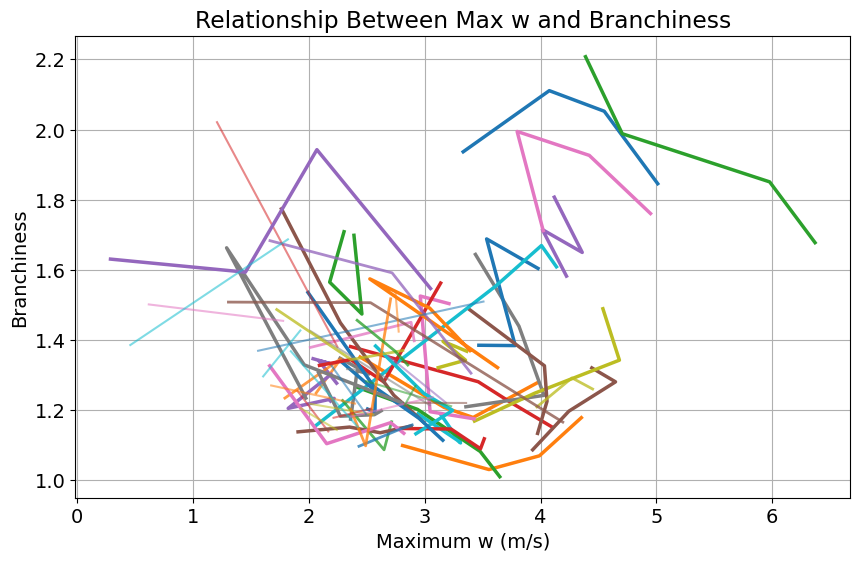

In [35]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load the NetCDF file
nc_file = '../cloud_results.nc'  # Update this path
dataset = Dataset(nc_file, 'r')

# Read max_w, surface areas, and sizes for each cloud at each timestep
max_ws = dataset.variables['max_w'][:]  # No transpose needed, shape (track, time)
cloud_surface_areas = dataset.variables['surface_area'][:]
cloud_sizes = dataset.variables['size'][:]

# Assume cloud size as volume for simplicity
cloud_volumes = cloud_sizes  # Use size directly if appropriate, or adjust calculation

# Calculate the surface area of a sphere with equivalent volume
sphere_surface_areas = 4 * np.pi * ((3 * cloud_volumes / (4 * np.pi))**(2/3))

# Calculate branchiness: ratio of cloud surface area to sphere surface area
branchiness = cloud_surface_areas / sphere_surface_areas

# Find the maximum lifespan of any cloud for normalization
lifespans = np.sum(~np.isnan(max_ws), axis=1)
max_lifespan = np.max(lifespans)

# Setup the plot
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})

# Iterate over each cloud (track)
for track_id in range(max_ws.shape[0]):
    # Extract the max_w and branchiness per cloud over time
    track_max_ws = max_ws[track_id, :]
    track_branchiness = branchiness[track_id, :]

    # Filter out NaNs for meaningful plotting
    valid = ~np.isnan(track_max_ws) & ~np.isnan(track_branchiness)
    track_times = np.arange(max_ws.shape[1])[valid]
    track_max_ws = track_max_ws[valid]
    track_branchiness = track_branchiness[valid]

    if len(track_times) > 1:  # Ensure there are enough points to plot
        # Calculate the alpha and line width based on lifespan
        lifespan_ratio = len(track_times) / max_lifespan
        alpha = 0.1 + 0.9 * lifespan_ratio  # From 10% to 100% opacity
        linewidth = 0.5 + 2 * lifespan_ratio  # From 1 to 3 width
        plt.plot(track_max_ws, track_branchiness, '-', label=f'Cloud {track_id+1}',
                 alpha=alpha, linewidth=linewidth)

plt.xlabel('Maximum w (m/s)')
plt.ylabel('Branchiness')
plt.title('Relationship Between Max w and Branchiness')
#plt.legend()
plt.grid(True)
plt.show()

#plt.savefig('max_w_branchiness_long_lived_darker.pdf', transparent=True, bbox_inches='tight')

dataset.close()


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_17028/1882861860.py:23: UserWarning: Warning: converting a masked element to nan.
  active_tracks = np.array([np.any(~np.isnan(max_ws[i])) for i in range(max_ws.shape[0])])


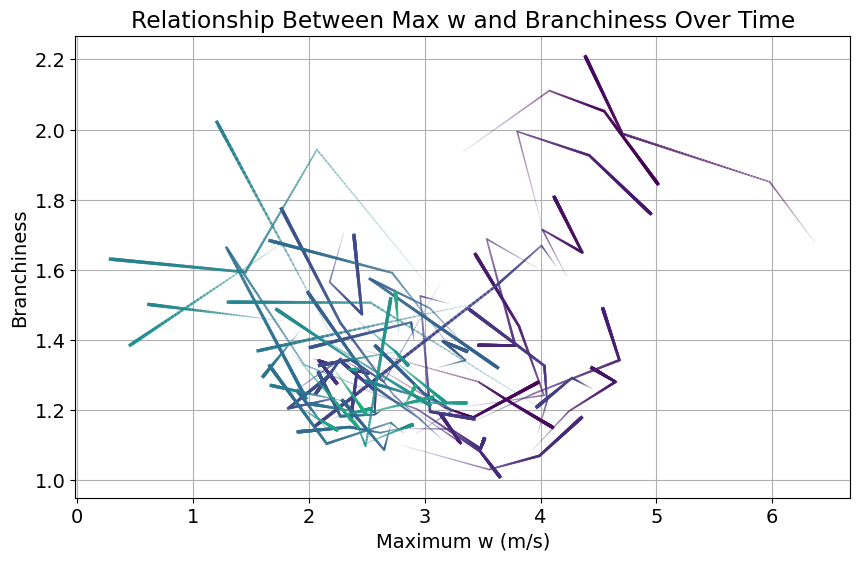

In [36]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load the NetCDF file
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Read max_w, surface areas, and sizes for each cloud at each timestep
max_ws = dataset.variables['max_w'][:]  # No transpose needed, shape (track, time)
cloud_surface_areas = dataset.variables['surface_area'][:]
cloud_sizes = dataset.variables['size'][:]

# Calculate the surface area of a sphere with equivalent volume
sphere_surface_areas = 4 * np.pi * ((3 * cloud_sizes / (4 * np.pi))**(2/3))

# Calculate branchiness: ratio of cloud surface area to sphere surface area
branchiness = cloud_surface_areas / sphere_surface_areas

# Setup the plot
plt.figure(figsize=(10, 6))
# Identify active tracks where there's at least one non-NaN max_w value
active_tracks = np.array([np.any(~np.isnan(max_ws[i])) for i in range(max_ws.shape[0])])
num_active_tracks = int(np.nansum(active_tracks))  # Use np.nansum to ignore NaNs in the sum

if num_active_tracks > 0:
    colors = plt.cm.viridis(np.linspace(0, 1, num_active_tracks))  # Generate colors for active tracks only
else:
    colors = []

# Counter for coloring
color_index = 0

# Iterate over each cloud (track)
for track_id in range(max_ws.shape[0]):
    if not active_tracks[track_id]:
        continue  # Skip inactive tracks
    
    track_max_ws = max_ws[track_id, :]
    track_branchiness = branchiness[track_id, :]

    # Filter out NaNs for meaningful plotting
    valid = ~np.isnan(track_max_ws) & ~np.isnan(track_branchiness)
    track_times = np.arange(max_ws.shape[1])[valid]
    track_max_ws = track_max_ws[valid]
    track_branchiness = track_branchiness[valid]
    
    # Calculate properties based on the position in the lifespan
    num_points = len(track_times)
    if num_points > 1 and len(colors) > 0:
        for i in range(num_points - 1):
            # Calculate alpha and linewidth based on the segment position in lifespan
            alpha_start = 0.1 + 0.9 * (i / (num_points - 1))
            alpha_end = 0.1 + 0.9 * ((i + 1) / (num_points - 1))
            start_linewidth = 0.5 + 2 * (i / (num_points - 1))
            end_linewidth = 0.5 + 2 * ((i + 1) / (num_points - 1))

            # Interpolate linewidth and alpha between the two points
            lin_space = np.linspace(start_linewidth, end_linewidth, num=50)
            alpha_space = np.linspace(alpha_start, alpha_end, num=50)
            x_values = np.linspace(track_max_ws[i], track_max_ws[i + 1], num=50)
            y_values = np.linspace(track_branchiness[i], track_branchiness[i + 1], num=50)

            # Plot each tiny segment with varying linewidth and alpha
            for j in range(len(x_values) - 1):
                plt.plot(x_values[j:j+2], y_values[j:j+2], '-', alpha=alpha_space[j], linewidth=lin_space[j], color=colors[color_index])

        color_index += 1  # Increment to the next color for the next active track

plt.xlabel('Maximum w (m/s)')
plt.ylabel('Branchiness')
plt.title('Relationship Between Max w and Branchiness Over Time')
plt.grid(True)
plt.show()

dataset.close()


# Movement of cloud centers (x-y plane)

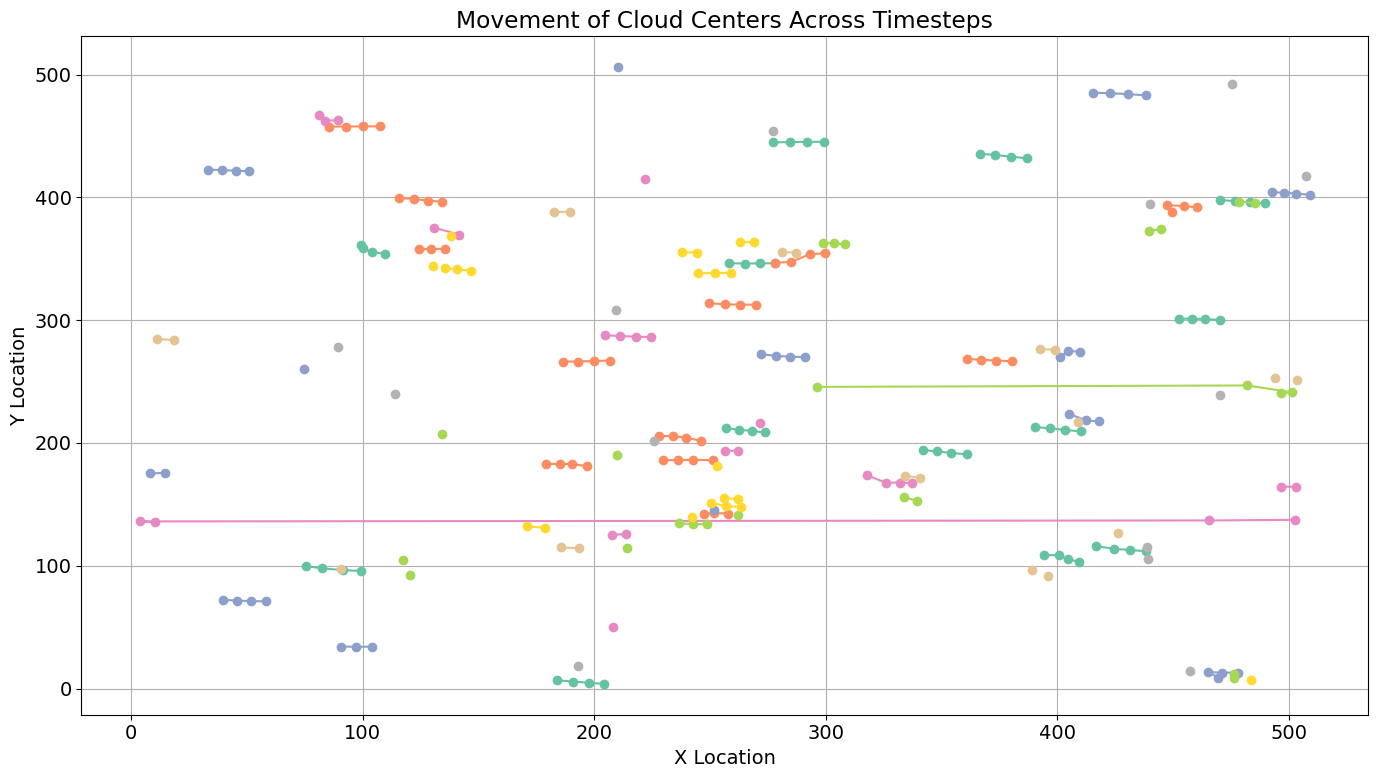

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import matplotlib.cm as cm

nc_file = '../cloud_results.nc'  # Replace this with your actual NetCDF file path
dataset = Dataset(nc_file, 'r')

# Reading cloud center locations
x_centers = dataset.variables['location_x'][:]  
y_centers = dataset.variables['location_y'][:]

# Determine which cloud tracks have any valid data
valid_cloud_indices = np.any(~np.isnan(x_centers), axis=1) & np.any(~np.isnan(y_centers), axis=1)
active_num_clouds = np.sum(valid_cloud_indices)  # Number of clouds with valid data

# Generate a color map for the active clouds
colors = cm.get_cmap('Set2', active_num_clouds)

# Plot for cloud center movements
plt.figure(figsize=(14, 8))
color_idx = 0  # To index into the colors array

for cloud_idx in range(len(valid_cloud_indices)):
    if valid_cloud_indices[cloud_idx]:  # Check if the cloud has any valid data
        valid_idx = ~np.isnan(x_centers[cloud_idx, :]) & ~np.isnan(y_centers[cloud_idx, :])
        if np.any(valid_idx):  # Ensure there are valid points to plot
            plt.plot(x_centers[cloud_idx, valid_idx], y_centers[cloud_idx, valid_idx], '-o', color=colors(color_idx), label=f'Cloud {cloud_idx+1}')
            color_idx += 1  # Move to the next color for the next active cloud

plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Movement of Cloud Centers Across Timesteps')
plt.grid(True)
plt.tight_layout()
plt.show()

dataset.close()


# Cloud height vs branchiness

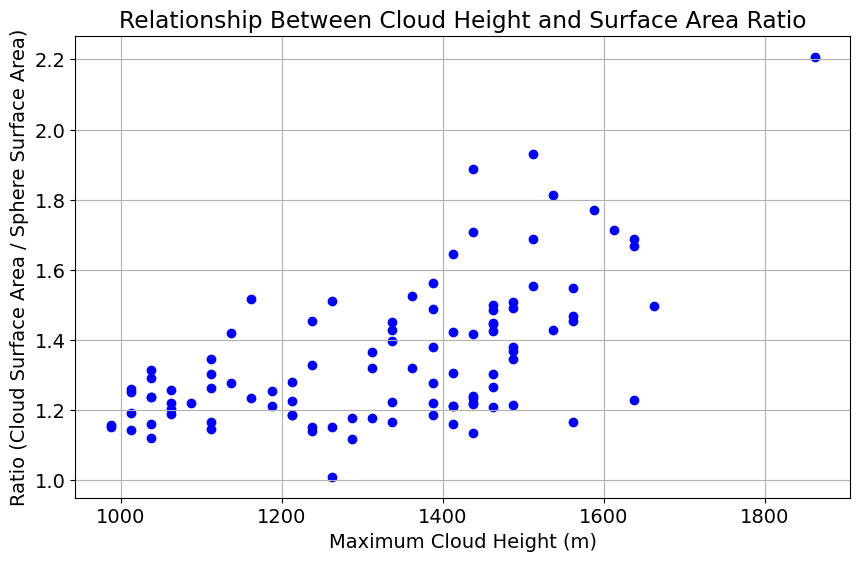

In [38]:

# Load the NetCDF file
nc_file = '../cloud_results.nc'  # Update this path
dataset = Dataset(nc_file, 'r')

# Read maximum heights, surface areas, and cloud sizes
max_heights = dataset.variables['max_height'][:].T  # Transpose to match ('time', 'track')
cloud_surface_areas = dataset.variables['surface_area'][:].T
cloud_sizes = dataset.variables['size'][:].T

# Calculate the maximum height for each cloud across all timesteps
max_cloud_heights = np.nanmax(max_heights, axis=0)

# Calculate maximum surface areas for each cloud across all timesteps
max_surface_areas = np.nanmax(cloud_surface_areas, axis=0)

# Assume cloud size as volume for simplicity (replace with actual volume if different)
cloud_volumes = np.nanmax(cloud_sizes, axis=0)  # Use maximum size as proxy for volume

# Calculate the surface area of a sphere with equivalent volume
# Surface area of a sphere: 4 * pi * r^2; Volume of a sphere: (4/3) * pi * r^3
# r = (3 * volume / (4 * pi))^(1/3)
# Surface area = 4 * pi * (3 * volume / (4 * pi))^(2/3)
sphere_surface_areas = 4 * np.pi * ((3 * cloud_volumes / (4 * np.pi))**(2/3))

# Calculate ratio of cloud surface area to sphere surface area
ratios = max_surface_areas / sphere_surface_areas

# Filter valid ratios and corresponding heights
valid_indices = (~np.isnan(ratios)) & (~np.isnan(max_cloud_heights))
ratios = ratios[valid_indices]
heights = max_cloud_heights[valid_indices]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heights, ratios, color='blue')
plt.xlabel('Maximum Cloud Height (m)')
plt.ylabel('Ratio (Cloud Surface Area / Sphere Surface Area)')
plt.title('Relationship Between Cloud Height and Surface Area Ratio')
plt.grid(True)
plt.show()

dataset.close()


# Cloud height vs branchiness (split into high and low w)

Requires two sets of cloud results. Each run with the same settings other than w identification threshold

In [39]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Define function to calculate ratios and heights
def calculate_ratios_and_heights(nc_file):
    dataset = Dataset(nc_file, 'r')
    max_heights = dataset.variables['max_height'][:].T
    cloud_surface_areas = dataset.variables['surface_area'][:].T
    cloud_sizes = dataset.variables['size'][:].T

    max_cloud_heights = np.nanmax(max_heights, axis=0)
    max_surface_areas = np.nanmax(cloud_surface_areas, axis=0)
    cloud_volumes = np.nanmax(cloud_sizes, axis=0)

    sphere_surface_areas = 4 * np.pi * ((3 * cloud_volumes / (4 * np.pi))**(2/3))
    ratios = max_surface_areas / sphere_surface_areas

    valid_indices = (~np.isnan(ratios)) & (~np.isnan(max_cloud_heights))
    ratios = ratios[valid_indices]
    heights = max_cloud_heights[valid_indices]

    dataset.close()
    return heights, ratios

# Load and calculate for both datasets
heights_high_w, ratios_high_w = calculate_ratios_and_heights('../cloud_results.nc')
heights_low_w, ratios_low_w = calculate_ratios_and_heights('../cloud_results_low_w.nc')

# Adjust font size for the entire plot
plt.rcParams.update({'font.size': 14})  # Increase text size by 1.5 times

# Create scatter plot
plt.figure(figsize=(10, 6), facecolor='none')  # Set the background color of the figure as transparent
plt.scatter(heights_high_w, ratios_high_w, color='red', label='High Vertical Velocity (>2 m/s)')
plt.scatter(heights_low_w, ratios_low_w, color='blue', label='Low Vertical Velocity (0-2 m/s)')
plt.xlabel('Maximum Cloud Height (m)')
plt.ylabel('Branchiness Ratio') # (Cloud Surface Area / Sphere Surface Area)
#plt.title('Relationship Between Cloud Height and Surface Area Ratio Across Different Vertical Velocities')
plt.legend()
plt.grid(True)

# Save the figure as a PDF with a transparent background
#plt.savefig('cloud_height_vs_surface_ratio.pdf', transparent=True, bbox_inches='tight')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: b'../cloud_results_low_w.nc'

# Individual cloud paths in x-y plane
plots each cloud path in a separate plot. Do NOT plot for more than a few clouds

In [ ]:

# import xarray as xr

# ds = xr.open_dataset('../cloud_results.nc')
# ids = ds['track']

# for i in range (0,len(ids)):
    
#     track_id = ids[i]

#     # Extract the locations of the cloud across all timesteps
#     location_x = ds['location_x'].sel(track=track_id)
#     location_y = ds['location_y'].sel(track=track_id)

#     # Plotting the cloud's movement
#     plt.figure(figsize=(10, 6))
#     plt.plot(location_x, location_y, marker='o', linestyle='-', markersize=5, label=f'Cloud {track_id} Movement')
#     plt.xlabel('X Location')
#     plt.ylabel('Y Location')
#     plt.title('Movement of Cloud Over Time')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# Some clustering analysis

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

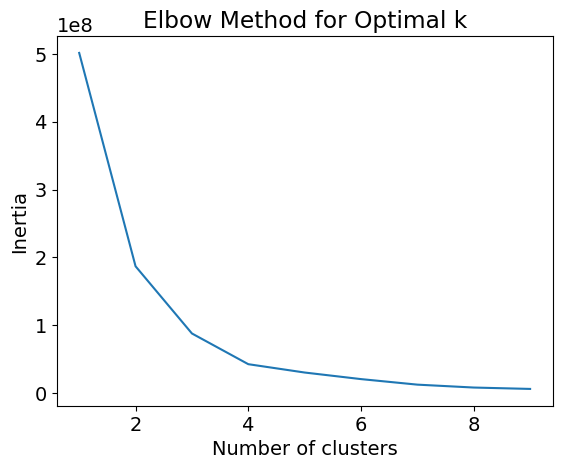

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


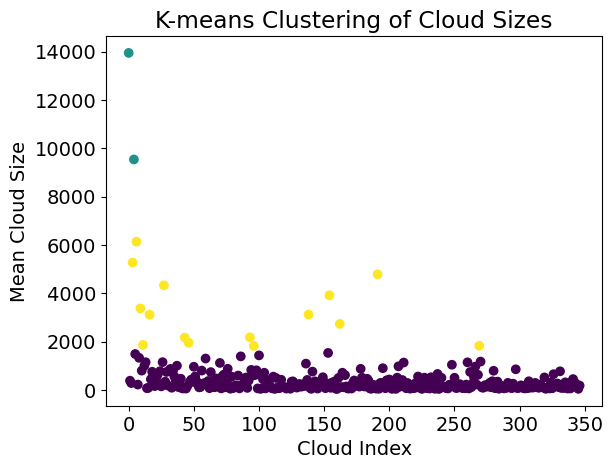

In [140]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Example data: mean size of each cloud over time
# This should be replaced with your actual data
cloud_sizes_mean = np.mean(cloud_sizes, axis=0).reshape(-1, 1)  # Reshape if necessary

# Determine the optimal number of clusters (k) - Example using the Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cloud_sizes_mean)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Perform K-means clustering with the chosen number of clusters (e.g., k=3)
kmeans = KMeans(n_clusters=3, random_state=0).fit(cloud_sizes_mean)

# Cluster labels for each cloud
labels = kmeans.labels_

# Visualize the clustering result
plt.scatter(range(len(cloud_sizes_mean)), cloud_sizes_mean, c=labels, cmap='viridis')
plt.xlabel('Cloud Index')
plt.ylabel('Mean Cloud Size')
plt.title('K-means Clustering of Cloud Sizes')
plt.show()


/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

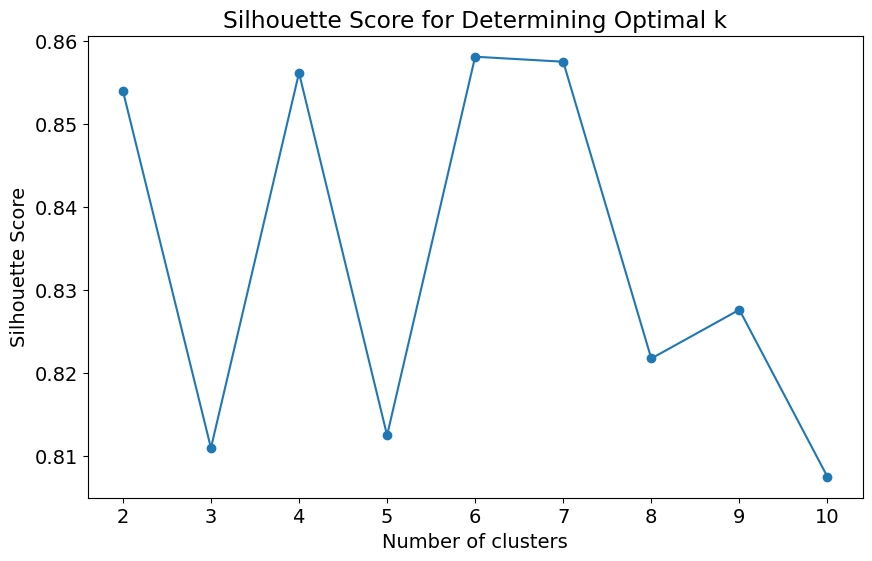

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal number of clusters: 6


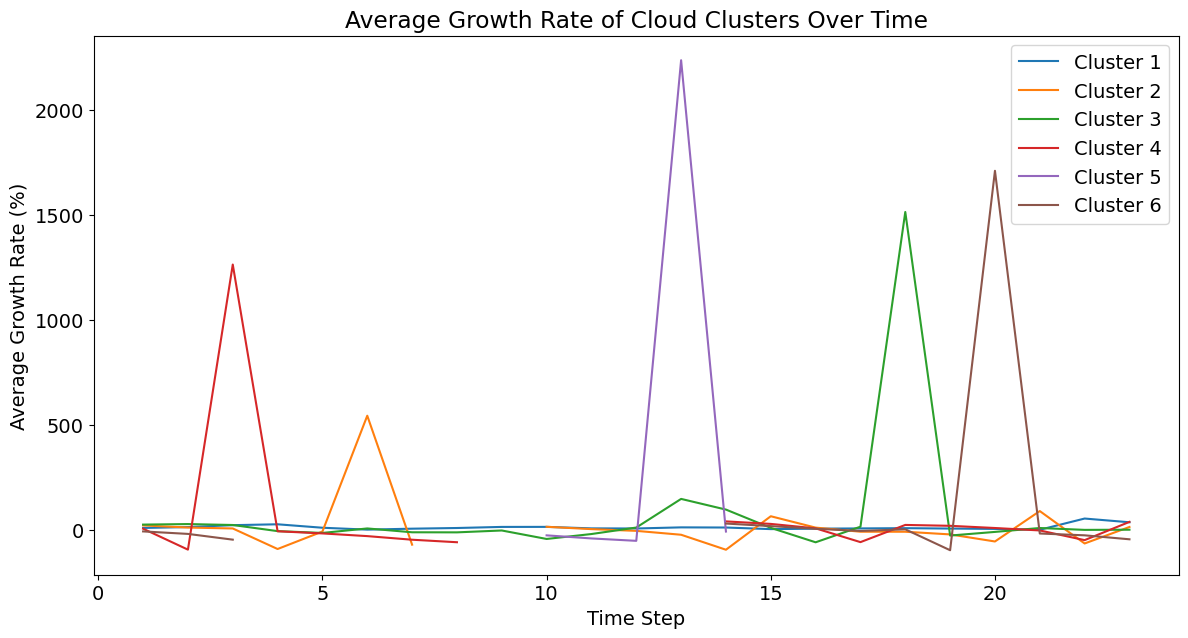

In [141]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assuming cloud_sizes is a NumPy array with shape (timesteps, clouds)
# Calculate growth rates
growth_rates = np.diff(cloud_sizes, axis=0) / cloud_sizes[:-1, :] * 100

# Handle NaN values in growth rates
imputer = SimpleImputer(strategy='mean')
growth_rates_imputed = imputer.fit_transform(growth_rates.T)  # Transpose to get clouds as rows

# Standardize the growth rates
scaler = StandardScaler()
growth_rates_scaled = scaler.fit_transform(growth_rates_imputed)

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
range_n_clusters = range(2, 11)  # Example range, adjust as needed
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(growth_rates_scaled)
    score = silhouette_score(growth_rates_scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Determining Optimal k')
plt.show()

# Choose the number of clusters based on the highest silhouette score
optimal_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(growth_rates_scaled)

# Visualize the clustering result by plotting the average growth rate of each cluster over time
plt.figure(figsize=(14, 7))
for i in range(optimal_k):
    cluster_growth_rates = growth_rates[:, labels == i]
    mean_growth = np.mean(cluster_growth_rates, axis=1)
    plt.plot(range(1, growth_rates.shape[0] + 1), mean_growth, label=f'Cluster {i+1}')

plt.xlabel('Time Step')
plt.ylabel('Average Growth Rate (%)')
plt.title('Average Growth Rate of Cloud Clusters Over Time')
plt.legend()
plt.show()
